In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
import math

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import statsmodels as stats
from MDAnalysis.analysis import distances, rdf

In [4]:
from polymer_MD_analysis import (pers_length, get_rg_pers_poly, bavg_pers_cnt, pos_bead_autocorr_RA,
                                 rouse_relax, zimm_relax_fit, zimm_relax_func, rh_block_avg, mean_sq_e2e, hydro_rad_poly,
                                obs_autocorr_RA, getPairStats, pair_regression, simple_regression_conf)

## 75 LGA: 25 EG PLGA-PEG/water simulations

### N = 8 75LGA:25EG in water

In [5]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n8_75LGA_25EG_wat = mda.Universe("n875LGA_25EG/n8_75LGA25EG_WAT.pdb", "n875LGA_25EG/NoWatn8_75LGA25EG.xtc")

In [6]:
n8_75LGA_25EG_wat.trajectory

<XTCReader n875LGA_25EG/NoWatn8_75LGA25EG.xtc with 18001 frames of 107 atoms>

In [7]:
len(n8_75LGA_25EG_wat.trajectory)

18001

In [8]:
#Select the polymer heavy atoms 
n8wat_75LGA25EG = n8_75LGA_25EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [9]:
np.unique(n8wat_75LGA25EG.resids)

array([1, 2, 3, 4, 5, 6, 7, 8])

In [10]:
# Get cosine theta values at frame 0 
crv_n8wat_75LGA25EG = pers_length(n8wat_75LGA25EG,8)
crv_n8wat_75LGA25EG

array([[1.        , 0.98803493, 0.9950912 , 0.99550568, 0.99619701,
        0.99581572, 0.99764441],
       [0.        , 1.        , 2.        , 3.        , 4.        ,
        5.        , 6.        ],
       [0.        , 8.87215658, 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

### Mean squared end to end distance 

In [11]:
n8_mon = 8 
start = 0
end = 18001
trj_len = np.arange(18001)

In [13]:
eVec_n8wat75LGA25EG, e2edis_n8wat75LGA25EG = mean_sq_e2e(n8wat_75LGA25EG, n8_75LGA_25EG_wat, n8_mon, start, end)

(0.0, 5.0)

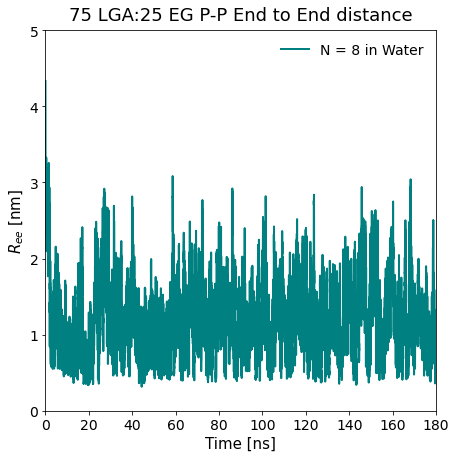

In [15]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat75LGA25EG[1]/10,linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [16]:
e2edis_n8wat75LGA25EG[1]

array([43.3223461 , 38.66534476, 36.02337592, ...,  5.37637379,
        5.27881797,  6.53567444])

In [17]:
t_corr = 2000
window_shift = 20

In [18]:
ACn8wat75LGA25EG_Ree, eqvar_n8wat75LGA25EG = obs_autocorr_RA(e2edis_n8wat75LGA25EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [19]:
ACn8wat75LGA25EG_Ree

array([[ 1.00000000e+00,  1.00645259e+00,  9.24399905e-01, ...,
        -1.32066512e-01, -1.46727109e-01, -1.27514081e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [20]:
eqvar_n8wat75LGA25EG

25.81332398501661

In [21]:
ACn8wat75LGA25EG_sqRee, evsqRee_n8wat75LGA25EG = obs_autocorr_RA(e2edis_n8wat75LGA25EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [22]:
np.sqrt(evsqRee_n8wat75LGA25EG)

154.38243731944723

(-1.0, 1.0)

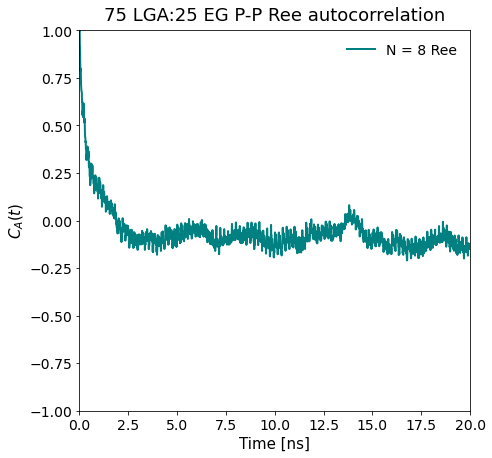

In [23]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Ree[1]/100, ACn8wat75LGA25EG_Ree[0],linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [24]:
n8wat75LGA25EG_rh = hydro_rad_poly(n8wat_75LGA25EG, n8_75LGA_25EG_wat, n8_mon, start, end)

(0.0, 2.0)

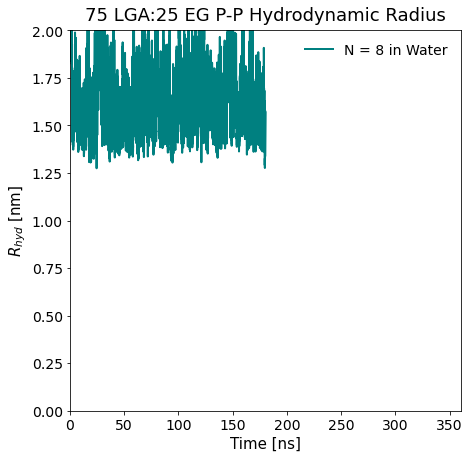

In [25]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat75LGA25EG_rh/10,linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,360)
plt.ylim(0,2)

#### Rh autocorrelation

In [26]:
ACn8wat75LGA25EG_Rh, eqvarRh_n8wat75LGA25EG = obs_autocorr_RA(n8wat75LGA25EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [27]:
ACn8wat75LGA25EG_Rh

array([[ 1.00000000e+00,  9.94282222e-01,  9.88607654e-01, ...,
        -4.42280086e-01, -5.96373701e-01, -4.35307826e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [28]:
eqvarRh_n8wat75LGA25EG

3.0022299153954464

(0.0, 20.0)

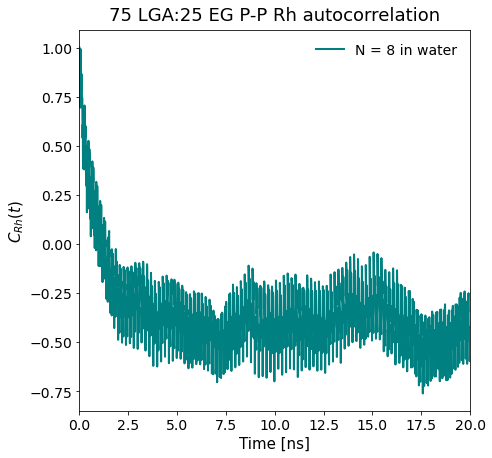

In [29]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rh[1]/100, ACn8wat75LGA25EG_Rh[0],linewidth=2, color='teal')
#plt.plot(A2n8plgapegwat_Ree[1]/100, ACn8plgapegwat_Ree[0],linewidth=2, color='r')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 8 75LGA:25EG in water

In [30]:
n875LGA25EG_rgens_wat, cor_n875LGA25EG_wat, n875LGA25EG_cos_wat, rgwat_n875LGA25EG = get_rg_pers_poly(n8wat_75LGA25EG, n8_75LGA_25EG_wat,
                                                                                                  start,end)

In [31]:
n875LGA25EG_rgens_wat[0].shape

(18001,)

In [32]:
cor_n875LGA25EG_wat[3]

array([0., 1., 2., 3., 4., 5., 6.])

In [33]:
n875LGA25EG_cos_wat

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.98803493,  0.97202942,  0.96688073, ...,  0.81034396,
         0.77634108,  0.79418193],
       [ 0.9950912 ,  0.96861927,  0.95214613, ...,  0.59358982,
         0.58086978,  0.6188905 ],
       ...,
       [ 0.99619701,  0.96369982,  0.91121402, ...,  0.05534022,
        -0.00935192,  0.20192343],
       [ 0.99581572,  0.96704478,  0.92745466, ...,  0.15976487,
         0.02306432,  0.03438274],
       [ 0.99764441,  0.97186929,  0.99778348, ..., -0.23367525,
        -0.33603075, -0.4305486 ]])

In [34]:
rgwat_n875LGA25EG

6.165025615718047

In [35]:
n875LGA25EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

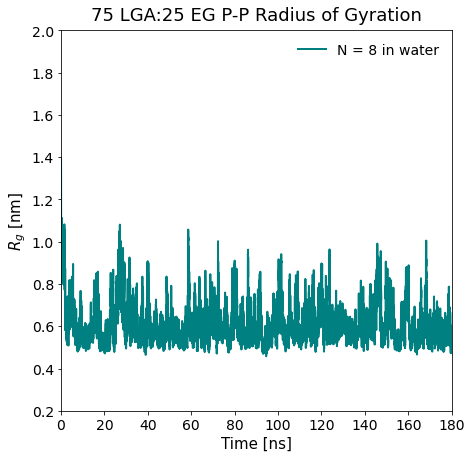

In [36]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n875LGA25EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [37]:
ACn8wat75LGA25EG_Rg, eqvarRg_n8wat75LGA25EG = obs_autocorr_RA(n875LGA25EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [38]:
ACn8wat75LGA25EG_Rg

array([[ 1.00000000e+00,  9.84652639e-01,  9.51564255e-01, ...,
        -4.93437191e-01, -5.55907779e-01, -5.13845030e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [39]:
eqvarRg_n8wat75LGA25EG

1.0056297724939398

(-1.0, 1.0)

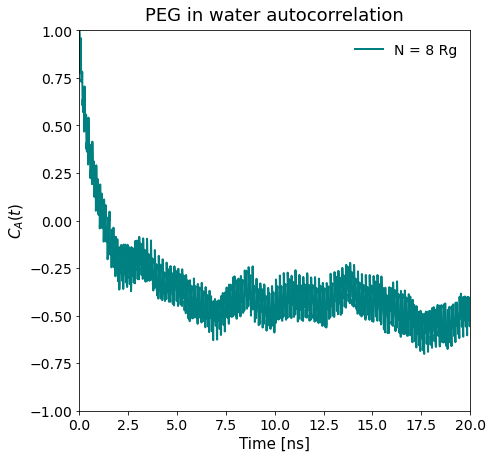

In [40]:
plt.figure(figsize=(7,7))
plt.title(r'PEG in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rg[1]/100, ACn8wat75LGA25EG_Rg[0],linewidth=2, color='teal')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [41]:
cb_n8plga = np.zeros(shape=(18001))
cb_n8pplinker = np.zeros(shape=(18001))
cb_n8peg = np.zeros(shape=(18001))
count = 0
for ts in n8_75LGA_25EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n8m1_plga = n8_75LGA_25EG_wat.select_atoms("resid 1")
    n8m2_plga = n8_75LGA_25EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n8pl_link = n8_75LGA_25EG_wat.select_atoms("resid 6")
    n8peg_link = n8_75LGA_25EG_wat.select_atoms("resid 7")
    # last two PEG residues 
    n8l1_peg = n8_75LGA_25EG_wat.select_atoms("resid 7")
    n8l2_peg = n8_75LGA_25EG_wat.select_atoms("resid 8")
    
    cb_n8plga[count] = mda.analysis.distances.distance_array(n8m1_plga.center_of_mass(), n8m2_plga.center_of_mass(), 
                                                   box=n8_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n8pplinker[count] = mda.analysis.distances.distance_array(n8pl_link.center_of_mass(), n8peg_link.center_of_mass(), 
                                                   box=n8_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n8peg[count] = mda.analysis.distances.distance_array(n8l1_peg.center_of_mass(), n8l2_peg.center_of_mass(), 
                                                   box=n8_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [42]:
COM_n8pp = np.zeros(shape=(3,2))
COM_n8pp[0,0] = np.mean(cb_n8plga)
COM_n8pp[1,0] = np.mean(cb_n8pplinker)
COM_n8pp[2,0] = np.mean(cb_n8peg)
COM_n8pp[0,1] = np.std(cb_n8plga)
COM_n8pp[1,1] = np.std(cb_n8pplinker)
COM_n8pp[2,1] = np.std(cb_n8peg)
COM_n8pp

array([[5.54207221, 0.72267236],
       [4.13269956, 0.39027402],
       [3.26959866, 0.13619941]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 8 75LGA:25EG/water

In [51]:
# x values
blen_n8pp = np.zeros(shape=n8_mon-1)
for i in range(n8_mon-1):
    if i < int(n8_mon-2):
        # PLGA contour length values
        if i == 0:
            blen_n8pp[i] = 0
        elif i != 0:
            blen_n8pp[i] = np.sum(blen_n8pp[i-1])+ COM_n8pp[0,0]    
    elif i == int(n8_mon-2):
        #PLGA-PEG linker length
        blen_n8pp[i] = np.sum(blen_n8pp[i-1]) + COM_n8pp[1,0]
    elif i > int(n8_mon-2):
    #    # PEG contour length values
        blen_n8pp[i] = np.sum(blen_n8pp[i-1]) + COM_n8pp[2,0]
        
blen_n8pp

array([ 0.        ,  5.54207221, 11.08414441, 16.62621662, 22.16828883,
       27.71036104, 31.84306059])

In [52]:
# Error prop. into natural log std deviation
mk_n8ppwat = cor_n875LGA25EG_wat[1]/cor_n875LGA25EG_wat[0]
mk_n8ppwat

array([0.        , 0.00987948, 0.04179014, 0.08956815, 0.15340862,
       0.2649216 , 0.47162875])

<ErrorbarContainer object of 3 artists>

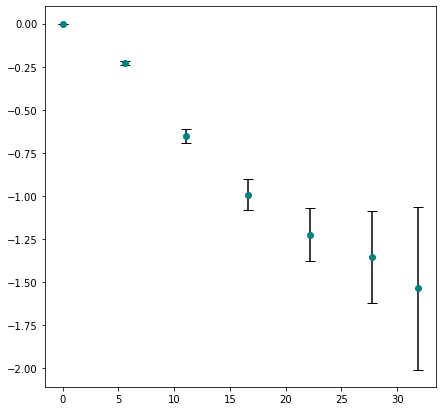

In [53]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n8pp, np.log(cor_n875LGA25EG_wat[0]), yerr=mk_n8ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [54]:
# All the points give the best fits for N = 6 peg in water
n8_blks75LGA25EG_wat , n875LGA25EG_lpwat = bavg_pers_cnt(5, n8wat_75LGA25EG, n8_75LGA_25EG_wat, blen_n8pp, 3, start, end)

0
3600
[1.         0.80167627 0.53287433 0.3830883  0.29865055 0.13807118
 0.05530324]
Lp [Angstroms]: 17.60870291285036
Error in Lp from fit [Angstroms], 95% CL : 38.45078544640902
R2 score: 0.9713131238906232
3600
7200
[1.         0.78973107 0.51260215 0.35109709 0.2946078  0.2323676
 0.14809234]
Lp [Angstroms]: 16.586691877783963
Error in Lp from fit [Angstroms], 95% CL : 35.71213816511131
R2 score: 0.9720883073847445
7200
10800
[1.         0.7905613  0.50761874 0.36532575 0.26249048 0.3032521
 0.25665755]
Lp [Angstroms]: 16.34770198661305
Error in Lp from fit [Angstroms], 95% CL : 36.79008234320126
R2 score: 0.9695840177574857
10800
14400
[1.         0.80175485 0.53863821 0.38765565 0.30369339 0.29443551
 0.31050861]
Lp [Angstroms]: 17.914893231406904
Error in Lp from fit [Angstroms], 95% CL : 37.55600835059988
R2 score: 0.9735006659056399
14400
18000
[1.         0.79321423 0.51085226 0.36451002 0.30611474 0.32284949
 0.30829281]
Lp [Angstroms]: 16.50224737782409
Error in Lp from f

In [55]:
n8_blks75LGA25EG_wat

{'Avg Hydrodynamic radius': array([16.29758513557828, 15.700211450141818, 16.037082791609304,
        16.091055132404406, 16.020813053698106], dtype=object),
 'Avg Radius of gyration': array([6.53045337, 5.96848951, 6.07041131, 6.14303215, 6.09768485]),
 'Avg Sq. radius of gyration': array([42.64682116, 35.62286702, 36.84989348, 37.73684404, 37.18176052]),
 'Avg end to end distance': array([13.72512554, 11.76378934, 12.94167611, 12.77620176, 13.52145842]),
 'Avg Sq. end to end distance': array([188.3790712 , 138.38673971, 167.48698053, 163.23133133,
        182.8298377 ]),
 'Avg persistence length': array([17.60870291, 16.58669188, 16.34770199, 17.91489323, 16.50224738])}

In [56]:
n875LGA25EG_lpwat

array([[ 1.76087029e+01,  1.65866919e+01,  1.63477020e+01,
         1.79148932e+01,  1.65022474e+01],
       [ 3.84507854e+01,  3.57121382e+01,  3.67900823e+01,
         3.75560084e+01,  3.75521454e+01],
       [-5.67901000e-02, -6.02892974e-02, -6.11706771e-02,
        -5.58194786e-02, -6.05978069e-02],
       [ 5.85118223e-03,  6.41113993e-03,  7.21069837e-03,
         5.21008267e-03,  7.23502095e-03]])

In [57]:
n875LGA25EG_lpwat[2]

array([-0.0567901 , -0.0602893 , -0.06117068, -0.05581948, -0.06059781])

In [58]:
np.mean(n875LGA25EG_lpwat[3])

0.00638362482998886

#### Block averaged Radius of gyration and persistence length, N = 8 75LGA:25EG/water

In [59]:
np.mean(n8_blks75LGA25EG_wat["Avg Radius of gyration"])

6.16201423754901

In [60]:
np.std(n8_blks75LGA25EG_wat["Avg Radius of gyration"])

0.19291910101821283

In [62]:
rg75LGA25EG_olig_wat =  pd.DataFrame(data=n8_blks75LGA25EG_wat["Avg Radius of gyration"], columns=['$R_{g}$ [Angstrom] N = 8 75LGA:25EG water'])
rg75LGA25EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 75LGA:25EG water
0,6.530453
1,5.968490
2,6.070411
3,6.143032
4,6.097685


In [63]:
pers_75LGA25EG_wat = pd.DataFrame(data=n8_blks75LGA25EG_wat["Avg persistence length"], columns=[r"$L_{p}$ [Angstrom] N = 8 75LGA:25EG water"])
pers_75LGA25EG_wat

,$L_{p}$ [Angstrom] N = 8 75LGA:25EG water
0,17.608703
1,16.586692
2,16.347702
3,17.914893
4,16.502247


### N = 12 75LGA:25EG in water

In [64]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n12_75LGA_25EG_wat = mda.Universe("n1275LGA_25EG/n12_75LGA25EG_WAT.pdb", "n1275LGA_25EG/NoWatn12_75LGA25EG.xtc")

In [65]:
n12_75LGA_25EG_wat.trajectory

<XTCReader n1275LGA_25EG/NoWatn12_75LGA25EG.xtc with 18001 frames of 159 atoms>

In [66]:
len(n12_75LGA_25EG_wat.trajectory)

18001

In [67]:
#Select the polymer heavy atoms 
n12wat_75LGA25EG = n12_75LGA_25EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [68]:
np.unique(n12wat_75LGA25EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [69]:
# Get cosine theta values at frame 0 
crv_n12wat_75LGA25EG = pers_length(n12wat_75LGA25EG,12)
crv_n12wat_75LGA25EG

array([[ 1.        ,  0.98558945,  0.98320639,  0.9923799 ,  0.99639407,
         0.99662608,  0.99573397,  0.99362378,  0.9899557 ,  0.99277824,
         0.98896078],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        ],
       [ 0.        ,  9.73869628, 10.51524392,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  8.12758643,  0.        ,
         8.52132593]])

### Mean squared end to end distance 

In [70]:
n12_mon = 12 
start = 0
end = 18001
trj_len = np.arange(18001)

In [71]:
eVec_n12wat75LGA25EG, e2edis_n12wat75LGA25EG = mean_sq_e2e(n12wat_75LGA25EG, n12_75LGA_25EG_wat, n12_mon, start, end)

(0.0, 5.0)

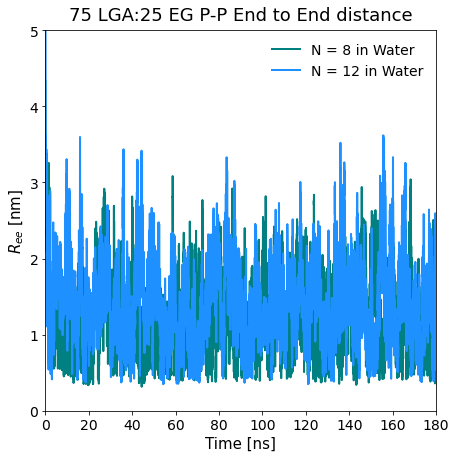

In [72]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat75LGA25EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat75LGA25EG[1]/10,linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [73]:
e2edis_n12wat75LGA25EG[1]

array([67.56586686, 62.28716355, 58.06585397, ..., 20.64964648,
       25.29639201, 25.3773174 ])

In [ ]:
t_corr = 2000
window_shift = 20

In [74]:
ACn12wat75LGA25EG_Ree, eqvar_n12wat75LGA25EG = obs_autocorr_RA(e2edis_n12wat75LGA25EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [75]:
ACn12wat75LGA25EG_Ree

array([[ 1.00000000e+00,  9.29332590e-01,  9.38070509e-01, ...,
        -6.47762905e-02, -5.90553765e-02, -8.39674301e-02],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [76]:
eqvar_n12wat75LGA25EG

32.440298149150664

In [77]:
ACn12wat75LGA25EG_sqRee, evsqRee_n12wat75LGA25EG = obs_autocorr_RA(e2edis_n12wat75LGA25EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [78]:
np.sqrt(evsqRee_n12wat75LGA25EG)

229.4397557023724

(-1.0, 1.0)

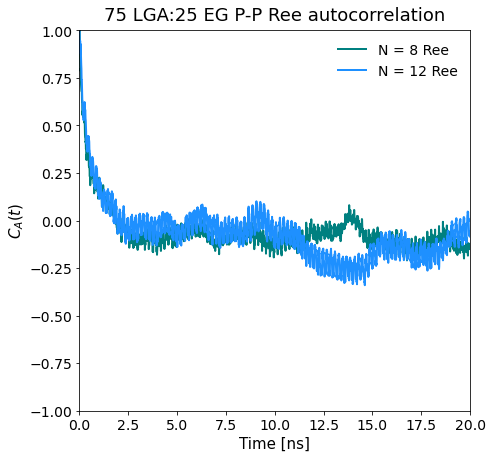

In [79]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Ree[1]/100, ACn8wat75LGA25EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Ree[1]/100, ACn12wat75LGA25EG_Ree[0],linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [80]:
n12wat75LGA25EG_rh = hydro_rad_poly(n12wat_75LGA25EG, n12_75LGA_25EG_wat, n12_mon, start, end)

(0.0, 2.0)

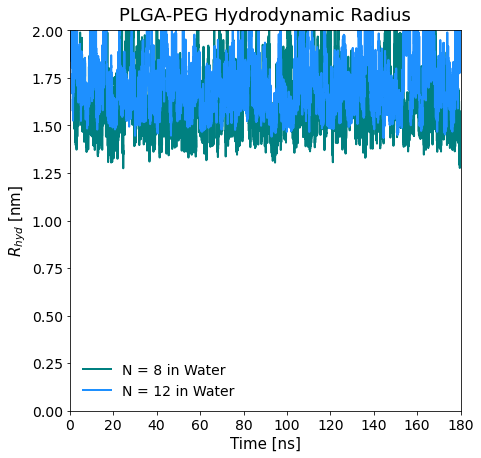

In [81]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat75LGA25EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat75LGA25EG_rh/10,linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [82]:
ACn12wat75LGA25EG_Rh, eqvarRh_n12wat75LGA25EG = obs_autocorr_RA(n12wat75LGA25EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [83]:
ACn12wat75LGA25EG_Rh

array([[ 1.00000000e+00,  9.17379985e-01,  1.03977564e+00, ...,
        -2.35765294e-01, -3.44673675e-01, -3.00444857e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [84]:
eqvarRh_n12wat75LGA25EG

2.6392908870965357

(0.0, 20.0)

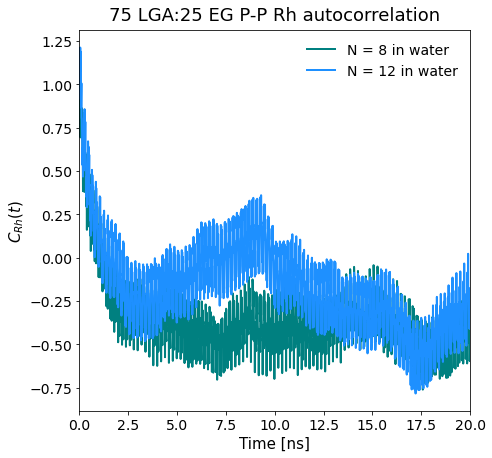

In [85]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rh[1]/100, ACn8wat75LGA25EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rh[1]/100, ACn12wat75LGA25EG_Rh[0],linewidth=2, color='dodgerblue')
#plt.plot(A2n12plgapegwat_Ree[1]/100, ACn12plgapegwat_Ree[0],linewidth=2, color='r')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 12 75LGA:25EG in water

In [86]:
n1275LGA25EG_rgens_wat, cor_n1275LGA25EG_wat, n1275LGA25EG_cos_wat, rgwat_n1275LGA25EG = get_rg_pers_poly(n12wat_75LGA25EG, n12_75LGA_25EG_wat,
                                                                                                  start,end)

In [87]:
n1275LGA25EG_rgens_wat[0].shape

(18001,)

In [88]:
cor_n1275LGA25EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [89]:
n1275LGA25EG_cos_wat

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.98558945,  0.97354148,  0.96894105, ...,  0.84760435,
         0.86040825,  0.8557294 ],
       [ 0.98320639,  0.96181267,  0.96471863, ...,  0.62535216,
         0.65475572,  0.6965073 ],
       ...,
       [ 0.9899557 ,  0.97542384,  0.97050055, ..., -0.01789437,
         0.16746246,  0.10592776],
       [ 0.99277824,  0.98982533,  0.95987436, ..., -0.32124028,
        -0.10835955, -0.20732851],
       [ 0.98896078,  0.99058832,  0.99907163, ..., -0.17403324,
        -0.00804155, -0.35989473]])

In [90]:
rgwat_n1275LGA25EG

7.166205180729382

In [91]:
n1275LGA25EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

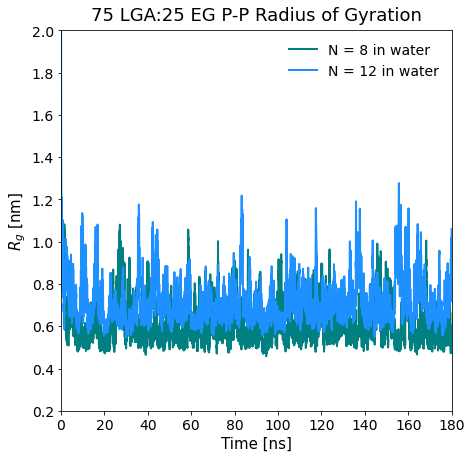

In [92]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n875LGA25EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1275LGA25EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [93]:
ACn12wat75LGA25EG_Rg, eqvarRg_n12wat75LGA25EG = obs_autocorr_RA(n1275LGA25EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [94]:
ACn12wat75LGA25EG_Rg

array([[ 1.00000000e+00,  9.46367192e-01,  1.00428609e+00, ...,
        -2.48749683e-01, -2.98805691e-01, -3.28558915e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [95]:
eqvarRg_n12wat75LGA25EG

1.2167293579924205

(-1.0, 1.0)

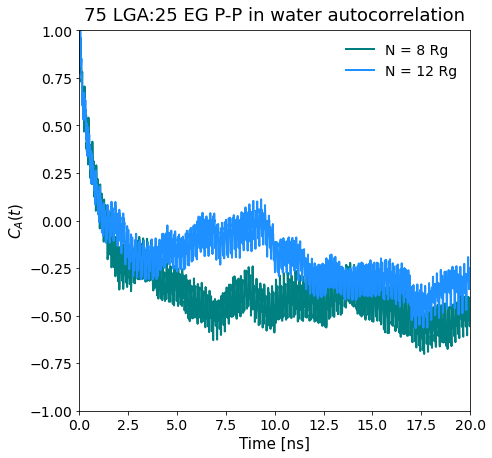

In [96]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rg[1]/100, ACn8wat75LGA25EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rg[1]/100, ACn12wat75LGA25EG_Rg[0],linewidth=2, color='dodgerblue')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [97]:
cb_n12plga = np.zeros(shape=(18001))
cb_n12pplinker = np.zeros(shape=(18001))
cb_n12peg = np.zeros(shape=(18001))
count = 0
for ts in n12_75LGA_25EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n12m1_plga = n12_75LGA_25EG_wat.select_atoms("resid 1")
    n12m2_plga = n12_75LGA_25EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n12pl_link = n12_75LGA_25EG_wat.select_atoms("resid 9")
    n12peg_link = n12_75LGA_25EG_wat.select_atoms("resid 10")
    # last two PEG residues 
    n12l1_peg = n12_75LGA_25EG_wat.select_atoms("resid 11")
    n12l2_peg = n12_75LGA_25EG_wat.select_atoms("resid 12")
    
    cb_n12plga[count] = mda.analysis.distances.distance_array(n12m1_plga.center_of_mass(), n12m2_plga.center_of_mass(), 
                                                   box=n12_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n12pplinker[count] = mda.analysis.distances.distance_array(n12pl_link.center_of_mass(), n12peg_link.center_of_mass(), 
                                                   box=n12_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n12peg[count] = mda.analysis.distances.distance_array(n12l1_peg.center_of_mass(), n12l2_peg.center_of_mass(), 
                                                   box=n12_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [98]:
COM_n12pp = np.zeros(shape=(3,2))
COM_n12pp[0,0] = np.mean(cb_n12plga)
COM_n12pp[1,0] = np.mean(cb_n12pplinker)
COM_n12pp[2,0] = np.mean(cb_n12peg)
COM_n12pp[0,1] = np.std(cb_n12plga)
COM_n12pp[1,1] = np.std(cb_n12pplinker)
COM_n12pp[2,1] = np.std(cb_n12peg)
COM_n12pp

array([[5.48411335, 0.73239456],
       [4.17681745, 0.37615911],
       [3.2489937 , 0.15360808]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 12 75LGA:25EG/water

In [99]:
# x values
blen_n12pp = np.zeros(shape=n12_mon-1)
for i in range(n12_mon-1):
    if i < int(n12_mon-3):
        # PLGA contour length values
        if i == 0:
            blen_n12pp[i] = 0
        elif i != 0:
            blen_n12pp[i] = np.sum(blen_n12pp[i-1])+ COM_n12pp[0,0]    
    elif i == int(n12_mon-3):
        #PLGA-PEG linker length
        blen_n12pp[i] = np.sum(blen_n12pp[i-1]) + COM_n12pp[1,0]
    elif i > int(n12_mon-3):
    #    # PEG contour length values
        blen_n12pp[i] = np.sum(blen_n12pp[i-1]) + COM_n12pp[2,0]
        
blen_n12pp

array([ 0.        ,  5.48411335, 10.9682267 , 16.45234006, 21.93645341,
       27.42056676, 32.90468011, 38.38879346, 43.87290682, 48.04972427,
       51.29871798])

In [100]:
# Error prop. into natural log std deviation
mk_n12ppwat = cor_n1275LGA25EG_wat[1]/cor_n1275LGA25EG_wat[0]
mk_n12ppwat

array([0.        , 0.00708316, 0.02436051, 0.05022078, 0.08048761,
       0.11996897, 0.13326884, 0.14840749, 0.19109841, 0.31102048,
       0.45152354])

<ErrorbarContainer object of 3 artists>

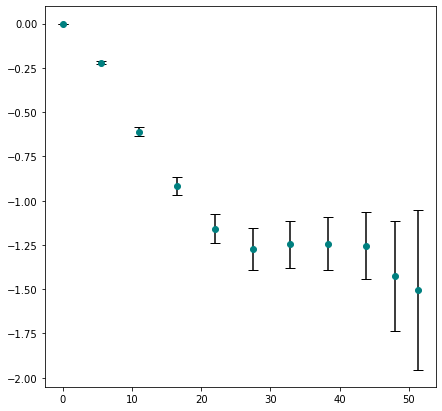

In [101]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n12pp, np.log(cor_n1275LGA25EG_wat[0]), yerr=mk_n12ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [102]:
# All the points give the best fits for N = 6 peg in water
n12_blks75LGA25EG_wat , n1275LGA25EG_lpwat = bavg_pers_cnt(5, n12wat_75LGA25EG, n12_75LGA_25EG_wat, blen_n12pp, 3, start, end)

0
3600
[1.         0.80811086 0.55015183 0.39939241 0.29227503 0.26051042
 0.27697436 0.26324761 0.25239171 0.24609777 0.26004404]
Lp [Angstroms]: 18.35499159625239
Error in Lp from fit [Angstroms], 95% CL : 38.63330950594003
R2 score: 0.973292865780467
3600
7200
[1.         0.81041701 0.55885477 0.39294082 0.28427339 0.22564554
 0.27914317 0.33172621 0.31939486 0.32947501 0.3155449 ]
Lp [Angstroms]: 18.850102220293227
Error in Lp from fit [Angstroms], 95% CL : 38.37003933209695
R2 score: 0.9749781029057025
7200
10800
[1.         0.78940173 0.52644925 0.39586111 0.32553898 0.31268902
 0.28684296 0.31587297 0.40467554 0.33958357 0.26527661]
Lp [Angstroms]: 17.095107238421075
Error in Lp from fit [Angstroms], 95% CL : 32.96281858689368
R2 score: 0.9774894856504223
10800
14400
[1.         0.80206641 0.53229956 0.3898742  0.32542727 0.30532439
 0.32298527 0.32422504 0.30256226 0.19160203 0.14152989]
Lp [Angstroms]: 17.394729180241814
Error in Lp from fit [Angstroms], 95% CL : 38.3338595165

In [103]:
n12_blks75LGA25EG_wat

{'Avg Hydrodynamic radius': array([17.24299276954031, 16.861524264321368, 16.783769534385463,
        17.091124794637782, 17.30062127985524], dtype=object),
 'Avg Radius of gyration': array([7.27537651, 6.99176141, 6.98842439, 7.22259766, 7.34409571]),
 'Avg Sq. radius of gyration': array([52.93110339, 48.88472757, 48.8380755 , 52.1659169 , 53.93574175]),
 'Avg end to end distance': array([16.32029717, 14.21898018, 15.55512983, 15.35627132, 14.9685626 ]),
 'Avg Sq. end to end distance': array([266.35209959, 202.17939747, 241.9620639 , 235.81506895,
        224.05786642]),
 'Avg persistence length': array([18.3549916 , 18.85010222, 17.09510724, 17.39472918, 18.06597476])}

In [104]:
n1275LGA25EG_lpwat

array([[ 1.83549916e+01,  1.88501022e+01,  1.70951072e+01,
         1.73947292e+01,  1.80659748e+01],
       [ 3.86333095e+01,  3.83700393e+01,  3.29628186e+01,
         3.83338595e+01,  3.63326553e+01],
       [-5.44810928e-02, -5.30501102e-02, -5.84962695e-02,
        -5.74886789e-02, -5.53526734e-02],
       [ 4.89912150e-03,  4.34450992e-03,  4.73993631e-03,
         5.98006013e-03,  4.61699947e-03]])

In [105]:
n1275LGA25EG_lpwat[2]

array([-0.05448109, -0.05305011, -0.05849627, -0.05748868, -0.05535267])

In [106]:
np.mean(n1275LGA25EG_lpwat[3])

0.004916125465402116

#### Block averaged Radius of gyration and persistence length, N = 12 75LGA:25EG/water

In [107]:
np.mean(n12_blks75LGA25EG_wat["Avg Radius of gyration"])

7.1644511349445255

In [108]:
np.std(n12_blks75LGA25EG_wat["Avg Radius of gyration"])

0.147488837033951

In [109]:
rg75LGA25EG_olig_wat[r"$R_{g}$ [Angstrom] N = 12 75LGA:25EG water"] = n12_blks75LGA25EG_wat["Avg Radius of gyration"]
rg75LGA25EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 75LGA:25EG water,$R_{g}$ [Angstrom] N = 12 75LGA:25EG water
0,6.530453,7.275377
1,5.968490,6.991761
2,6.070411,6.988424
3,6.143032,7.222598
4,6.097685,7.344096


In [110]:
pers_75LGA25EG_wat[r"$L_{p}$ [Angstrom] N = 12 75LGA:25EG water"] = n12_blks75LGA25EG_wat["Avg persistence length"]
pers_75LGA25EG_wat

,$L_{p}$ [Angstrom] N = 8 75LGA:25EG water,$L_{p}$ [Angstrom] N = 12 75LGA:25EG water
0,17.608703,18.354992
1,16.586692,18.850102
2,16.347702,17.095107
3,17.914893,17.394729
4,16.502247,18.065975


### N = 16 75LGA:25EG in water

In [111]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n16_75LGA_25EG_wat = mda.Universe("n1675LGA_25EG/n16_75LGA25EG_WAT.pdb", "n1675LGA_25EG/NoWatn16_75LGA25EG.xtc")

In [112]:
n16_75LGA_25EG_wat.trajectory

<XTCReader n1675LGA_25EG/NoWatn16_75LGA25EG.xtc with 18001 frames of 211 atoms>

In [113]:
len(n16_75LGA_25EG_wat.trajectory)

18001

In [114]:
#Select the polymer heavy atoms 
n16wat_75LGA25EG = n16_75LGA_25EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [115]:
np.unique(n16wat_75LGA25EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [116]:
# Get cosine theta values at frame 0 
crv_n16wat_75LGA25EG = pers_length(n16wat_75LGA25EG,16)
crv_n16wat_75LGA25EG

array([[ 1.        ,  0.98419049,  0.97856045,  0.98055057,  0.99523252,
         0.99728202,  0.99661822,  0.99666043,  0.99734147,  0.99718421,
         0.99571106,  0.99566703,  0.99494682,  0.99325609,  0.98879304],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ],
       [ 0.        , 10.2016553 , 11.88569243, 11.31872454,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  8.58594298]])

### Mean squared end to end distance 

In [117]:
n16_mon = 16
start = 0
end = 18001
trj_len = np.arange(18001)

In [118]:
eVec_n16wat75LGA25EG, e2edis_n16wat75LGA25EG = mean_sq_e2e(n16wat_75LGA25EG, n16_75LGA_25EG_wat, n16_mon, start, end)

(0.0, 5.0)

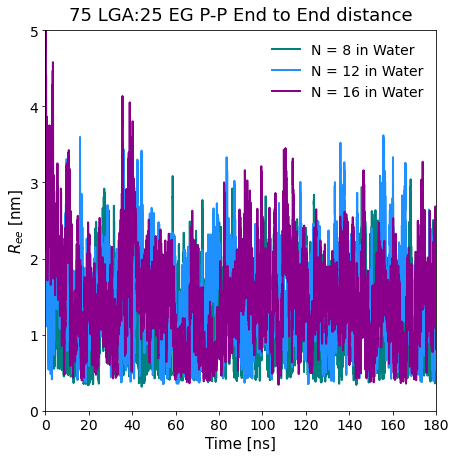

In [119]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat75LGA25EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat75LGA25EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat75LGA25EG[1]/10,linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [120]:
e2edis_n16wat75LGA25EG[1]

array([92.30218983, 85.72692618, 77.1119475 , ..., 10.10409893,
        9.23253773,  9.44438762])

In [ ]:
t_corr = 2000
window_shift = 20

In [121]:
ACn16wat75LGA25EG_Ree, eqvar_n16wat75LGA25EG = obs_autocorr_RA(e2edis_n16wat75LGA25EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [122]:
ACn16wat75LGA25EG_Ree

array([[ 1.00000000e+00,  9.51043204e-01,  9.37023561e-01, ...,
        -3.54584929e-01, -3.43125069e-01, -3.29453551e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [123]:
eqvar_n16wat75LGA25EG

45.239079285084784

In [124]:
ACn16wat75LGA25EG_sqRee, evsqRee_n16wat75LGA25EG = obs_autocorr_RA(e2edis_n16wat75LGA25EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [125]:
np.sqrt(evsqRee_n16wat75LGA25EG)

365.67549151124143

(-1.0, 1.0)

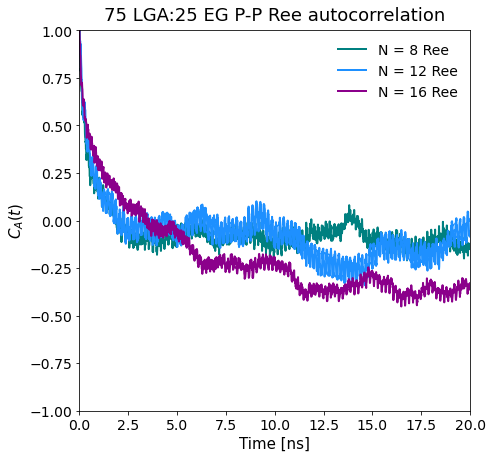

In [126]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Ree[1]/100, ACn8wat75LGA25EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn16wat75LGA25EG_Ree[1]/100, ACn12wat75LGA25EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Ree[1]/100, ACn16wat75LGA25EG_Ree[0],linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree' ], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [127]:
n16wat75LGA25EG_rh = hydro_rad_poly(n16wat_75LGA25EG, n16_75LGA_25EG_wat, n16_mon, start, end)

(0.0, 2.0)

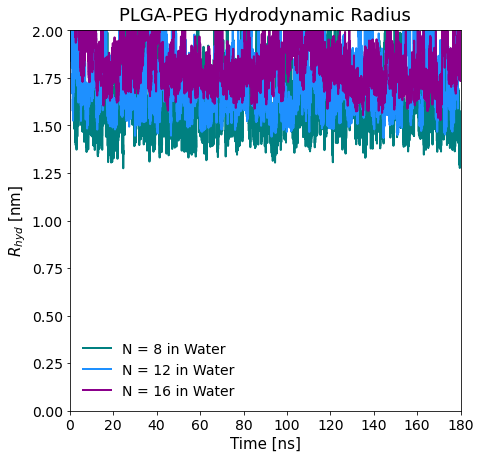

In [128]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat75LGA25EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat75LGA25EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat75LGA25EG_rh/10,linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water', 'N = 16 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [129]:
ACn16wat75LGA25EG_Rh, eqvarRh_n16wat75LGA25EG = obs_autocorr_RA(n16wat75LGA25EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [130]:
ACn16wat75LGA25EG_Rh

array([[ 1.00000000e+00,  9.14565468e-01,  1.05442449e+00, ...,
        -1.56173426e+00, -1.61124955e+00, -1.59814216e+00],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [131]:
eqvarRh_n16wat75LGA25EG

2.906896864594046

(0.0, 20.0)

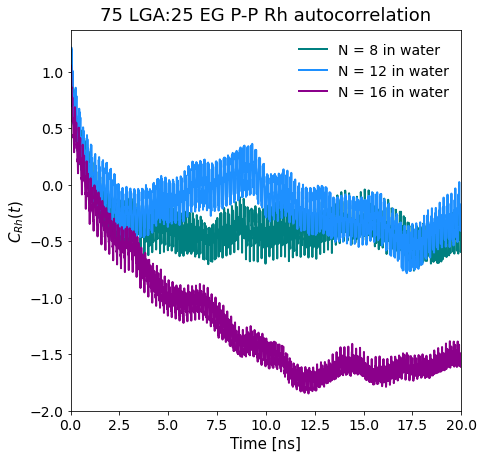

In [132]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rh[1]/100, ACn8wat75LGA25EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rh[1]/100, ACn12wat75LGA25EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rh[1]/100, ACn16wat75LGA25EG_Rh[0],linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 16 75LGA:25EG in water

In [133]:
n1675LGA25EG_rgens_wat, cor_n1675LGA25EG_wat, n1675LGA25EG_cos_wat, rgwat_n1675LGA25EG = get_rg_pers_poly(n16wat_75LGA25EG, n16_75LGA_25EG_wat,
                                                                                                  start,end)

In [134]:
n1675LGA25EG_rgens_wat[0].shape

(18001,)

In [135]:
cor_n1675LGA25EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [136]:
n1675LGA25EG_cos_wat

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.98419049,  0.97878123,  0.9693041 , ...,  0.84905281,
         0.83352297,  0.82707831],
       [ 0.97856045,  0.96659592,  0.93968861, ...,  0.61363798,
         0.5941832 ,  0.57642364],
       ...,
       [ 0.99494682,  0.98448544,  0.95515461, ...,  0.75251716,
         0.70765193,  0.71304799],
       [ 0.99325609,  0.98286048,  0.93369344, ...,  0.52248594,
         0.46159693,  0.45192662],
       [ 0.98879304,  0.98052151,  0.91600795, ...,  0.18034393,
         0.05284873, -0.0067241 ]])

In [137]:
rgwat_n1675LGA25EG

7.925742635711573

In [138]:
n1675LGA25EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

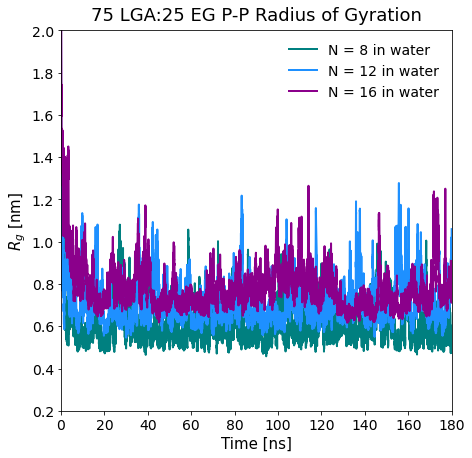

In [139]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n875LGA25EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1275LGA25EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1675LGA25EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [140]:
ACn16wat75LGA25EG_Rg, eqvarRg_n16wat75LGA25EG = obs_autocorr_RA(n1675LGA25EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [141]:
ACn16wat75LGA25EG_Rg

array([[ 1.00000000e+00,  9.38847352e-01,  9.88686261e-01, ...,
        -7.28878078e-01, -7.33210842e-01, -6.95976679e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [142]:
eqvarRg_n16wat75LGA25EG

1.7698654453823224

(-1.0, 1.0)

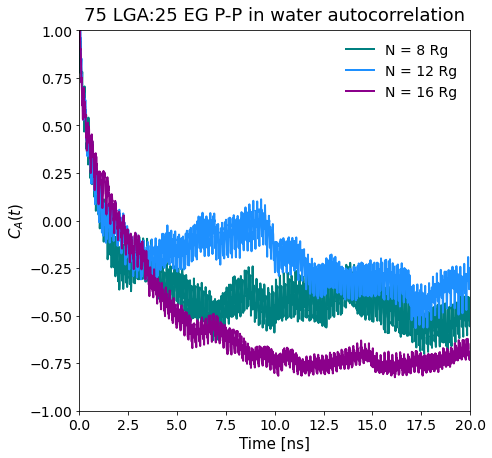

In [143]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rg[1]/100, ACn8wat75LGA25EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rg[1]/100, ACn12wat75LGA25EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rg[1]/100, ACn16wat75LGA25EG_Rg[0],linewidth=2, color='darkmagenta')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [144]:
cb_n16plga = np.zeros(shape=(18001))
cb_n16pplinker = np.zeros(shape=(18001))
cb_n16peg = np.zeros(shape=(18001))
count = 0
for ts in n16_75LGA_25EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n16m1_plga = n16_75LGA_25EG_wat.select_atoms("resid 1")
    n16m2_plga = n16_75LGA_25EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n16pl_link = n16_75LGA_25EG_wat.select_atoms("resid 12")
    n16peg_link = n16_75LGA_25EG_wat.select_atoms("resid 13")
    # last two PEG residues 
    n16l1_peg = n16_75LGA_25EG_wat.select_atoms("resid 15")
    n16l2_peg = n16_75LGA_25EG_wat.select_atoms("resid 16")
    
    cb_n16plga[count] = mda.analysis.distances.distance_array(n16m1_plga.center_of_mass(), n16m2_plga.center_of_mass(), 
                                                   box=n16_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n16pplinker[count] = mda.analysis.distances.distance_array(n16pl_link.center_of_mass(), n16peg_link.center_of_mass(), 
                                                   box=n16_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n16peg[count] = mda.analysis.distances.distance_array(n16l1_peg.center_of_mass(), n16l2_peg.center_of_mass(), 
                                                   box=n16_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [145]:
COM_n16pp = np.zeros(shape=(3,2))
COM_n16pp[0,0] = np.mean(cb_n16plga)
COM_n16pp[1,0] = np.mean(cb_n16pplinker)
COM_n16pp[2,0] = np.mean(cb_n16peg)
COM_n16pp[0,1] = np.std(cb_n16plga)
COM_n16pp[1,1] = np.std(cb_n16pplinker)
COM_n16pp[2,1] = np.std(cb_n16peg)
COM_n16pp

array([[5.43540914, 0.77118441],
       [4.22102912, 0.3510382 ],
       [3.24023962, 0.15149497]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 16 75LGA:25EG/water

In [146]:
# x values
blen_n16pp = np.zeros(shape=n16_mon-1)
for i in range(n16_mon-1):
    if i < int(n16_mon-4):
        # PLGA contour length values
        if i == 0:
            blen_n16pp[i] = 0
        elif i != 0:
            blen_n16pp[i] = np.sum(blen_n16pp[i-1])+ COM_n16pp[0,0]    
    elif i == int(n16_mon-4):
        #PLGA-PEG linker length
        blen_n16pp[i] = np.sum(blen_n16pp[i-1]) + COM_n16pp[1,0]
    elif i > int(n16_mon-4):
    #    # PEG contour length values
        blen_n16pp[i] = np.sum(blen_n16pp[i-1]) + COM_n16pp[2,0]
        
blen_n16pp

array([ 0.        ,  5.43540914, 10.87081829, 16.30622743, 21.74163658,
       27.17704572, 32.61245487, 38.04786401, 43.48327316, 48.9186823 ,
       54.35409145, 59.78950059, 64.01052971, 67.25076933, 70.49100895])

In [147]:
# Error prop. into natural log std deviation
mk_n16ppwat = cor_n1675LGA25EG_wat[1]/cor_n1675LGA25EG_wat[0]
mk_n16ppwat

array([0.        , 0.00594645, 0.02021731, 0.03511251, 0.05350805,
       0.08208544, 0.10718825, 0.12365532, 0.1751326 , 0.22216053,
       0.3016892 , 0.31891084, 0.4755341 , 0.50312361, 0.4575428 ])

<ErrorbarContainer object of 3 artists>

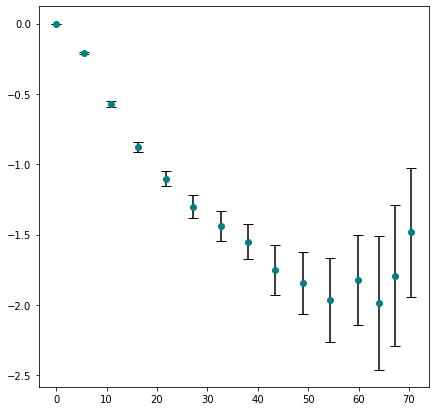

In [148]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n16pp, np.log(cor_n1675LGA25EG_wat[0]), yerr=mk_n16ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [149]:
# All the points give the best fits for N = 6 peg in water
n16_blks75LGA25EG_wat , n1675LGA25EG_lpwat = bavg_pers_cnt(5, n16wat_75LGA25EG, n16_75LGA_25EG_wat, blen_n16pp, 3, start, end)

0
3600
[1.         0.82685932 0.60812637 0.45833725 0.38128851 0.33288572
 0.30665007 0.23689951 0.18095105 0.15678391 0.16195502 0.19743716
 0.22127734 0.2261821  0.21954928]
Lp [Angstroms]: 21.856489478796423
Error in Lp from fit [Angstroms], 95% CL : 37.75949659183129
R2 score: 0.9818488349322523
3600
7200
[ 1.          0.79186315  0.53058709  0.40249952  0.31258495  0.23632161
  0.18810015  0.24005847  0.24958751  0.23993727  0.18123641  0.13520528
 -0.0138594   0.05101048  0.13014626]
Negative cosine theta values present, still doing linear fit...
Lp [Angstroms]: 17.15259226100298
Error in Lp from fit [Angstroms], 95% CL : 33.1640244178601
R2 score: 0.97736909971674
7200
10800
[ 1.          0.81492788  0.54907663  0.39708107  0.30663307  0.24464963
  0.23727544  0.21387829  0.14210363  0.07158199  0.04784733  0.07509379
  0.05507442  0.01226855 -0.02400538]
Negative cosine theta values present, still doing linear fit...
Lp [Angstroms]: 18.132619211714903
Error in Lp from fit [Angs

In [150]:
n16_blks75LGA25EG_wat

{'Avg Hydrodynamic radius': array([19.124909971958395, 18.002271301098414, 18.270291574567825,
        18.0494693279778, 17.848701487498627], dtype=object),
 'Avg Radius of gyration': array([8.74228945, 7.47133288, 7.99995221, 7.63541198, 7.71638162]),
 'Avg Sq. radius of gyration': array([76.42762482, 55.82081507, 63.99923541, 58.29951606, 59.54254534]),
 'Avg end to end distance': array([18.85231539, 16.07042771, 14.85579259, 16.56925733, 14.36013429]),
 'Avg Sq. end to end distance': array([355.40979574, 258.25864694, 220.69457342, 274.54028859,
        206.21345673]),
 'Avg persistence length': array([21.85648948, 17.15259226, 18.13261921, 18.06313067, 19.94874628])}

In [151]:
n1675LGA25EG_lpwat

array([[ 2.18564895e+01,  1.71525923e+01,  1.81326192e+01,
         1.80631307e+01,  1.99487463e+01],
       [ 3.77594966e+01,  3.31640244e+01,  4.22024952e+01,
         3.80940779e+01,  3.69872291e+01],
       [-4.57530017e-02, -5.83002257e-02, -5.51492307e-02,
        -5.53613888e-02, -5.01284635e-02],
       [ 2.28661758e-03,  4.65027007e-03,  6.02971620e-03,
         4.98890939e-03,  3.16157834e-03]])

In [152]:
n1675LGA25EG_lpwat[2]

array([-0.045753  , -0.05830023, -0.05514923, -0.05536139, -0.05012846])

In [153]:
np.mean(n1675LGA25EG_lpwat[3])

0.004223418314269475

#### Block averaged Radius of gyration and persistence length, N = 16 75LGA:25EG/water

In [154]:
np.mean(n16_blks75LGA25EG_wat["Avg Radius of gyration"])

7.9130736291936525

In [155]:
np.std(n16_blks75LGA25EG_wat["Avg Radius of gyration"])

0.4485678072923565

In [156]:
rg75LGA25EG_olig_wat[r"$R_{g}$ [Angstrom] N = 16 75LGA:25EG water"] = n16_blks75LGA25EG_wat["Avg Radius of gyration"]
rg75LGA25EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 75LGA:25EG water,$R_{g}$ [Angstrom] N = 12 75LGA:25EG water,$R_{g}$ [Angstrom] N = 16 75LGA:25EG water
0,6.530453,7.275377,8.742289
1,5.968490,6.991761,7.471333
2,6.070411,6.988424,7.999952
3,6.143032,7.222598,7.635412
4,6.097685,7.344096,7.716382


In [157]:
pers_75LGA25EG_wat[r"$L_{p}$ [Angstrom] N = 16 75LGA:25EG water"] = n16_blks75LGA25EG_wat["Avg persistence length"]
pers_75LGA25EG_wat

,$L_{p}$ [Angstrom] N = 8 75LGA:25EG water,$L_{p}$ [Angstrom] N = 12 75LGA:25EG water,$L_{p}$ [Angstrom] N = 16 75LGA:25EG water
0,17.608703,18.354992,21.856489
1,16.586692,18.850102,17.152592
2,16.347702,17.095107,18.132619
3,17.914893,17.394729,18.063131
4,16.502247,18.065975,19.948746


### N = 20 75LGA:25EG in water

In [158]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n20_75LGA_25EG_wat = mda.Universe("n2075LGA_25EG/n20_75LGA25EG_WAT.pdb", "n2075LGA_25EG/NoWatn20_75LGA25EG.xtc")

In [159]:
n20_75LGA_25EG_wat.trajectory

<XTCReader n2075LGA_25EG/NoWatn20_75LGA25EG.xtc with 18001 frames of 263 atoms>

In [160]:
len(n20_75LGA_25EG_wat.trajectory)

18001

In [161]:
#Select the polymer heavy atoms 
n20wat_75LGA25EG = n20_75LGA_25EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [162]:
np.unique(n20wat_75LGA25EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [163]:
# Get cosine theta values at frame 0 
crv_n20wat_75LGA25EG = pers_length(n20wat_75LGA25EG,20)
crv_n20wat_75LGA25EG

array([[ 1.        ,  0.99102659,  0.98633825,  0.98151673,  0.97964466,
         0.99124595,  0.99651721,  0.99717112,  0.9971751 ,  0.9971995 ,
         0.99694254,  0.99628388,  0.99545247,  0.99508636,  0.99450772,
         0.99443257,  0.99302304,  0.99121021,  0.98422035],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        ],
       [ 0.        ,  0.        ,  9.48170457, 11.0331162 , 11.58020632,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 10.19199237]])

### Mean squared end to end distance 

In [164]:
n20_mon = 20
start = 0
end = 18001
trj_len = np.arange(18001)

In [165]:
eVec_n20wat75LGA25EG, e2edis_n20wat75LGA25EG = mean_sq_e2e(n20wat_75LGA25EG, n20_75LGA_25EG_wat, n20_mon, start, end)

(0.0, 5.0)

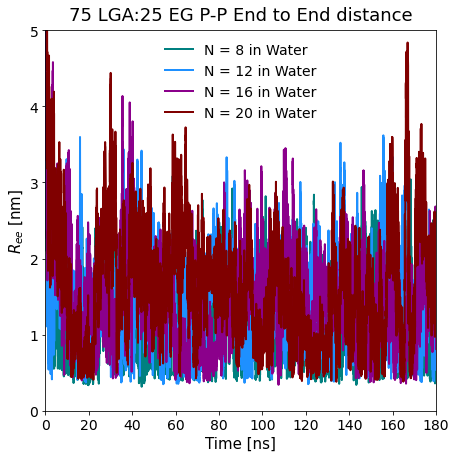

In [166]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat75LGA25EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat75LGA25EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat75LGA25EG[1]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, e2edis_n20wat75LGA25EG[1]/10,linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water','N = 20 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [167]:
e2edis_n20wat75LGA25EG[1]

array([116.41372239, 105.89553743,  99.57650458, ...,  15.63900316,
        15.62023719,  16.20401574])

In [ ]:
t_corr = 2000
window_shift = 20

In [168]:
ACn20wat75LGA25EG_Ree, eqvar_n20wat75LGA25EG = obs_autocorr_RA(e2edis_n20wat75LGA25EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [169]:
ACn20wat75LGA25EG_Ree

array([[ 1.00000000e+00,  9.62260982e-01,  9.45098205e-01, ...,
        -4.40106091e-02, -3.29012968e-02, -3.76201411e-02],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [170]:
eqvar_n20wat75LGA25EG

75.70300895942898

In [171]:
ACn20wat75LGA25EG_sqRee, evsqRee_n20wat75LGA25EG = obs_autocorr_RA(e2edis_n20wat75LGA25EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [172]:
np.sqrt(evsqRee_n20wat75LGA25EG)

627.2455774160893

(-1.0, 1.0)

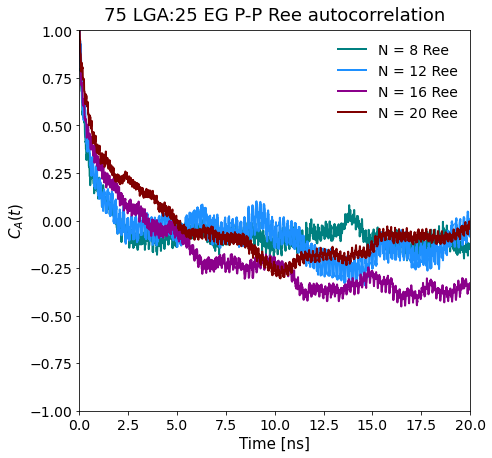

In [173]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Ree[1]/100, ACn8wat75LGA25EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Ree[1]/100, ACn12wat75LGA25EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Ree[1]/100, ACn16wat75LGA25EG_Ree[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Ree[1]/100, ACn20wat75LGA25EG_Ree[0],linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree','N = 20 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [174]:
n20wat75LGA25EG_rh = hydro_rad_poly(n20wat_75LGA25EG, n20_75LGA_25EG_wat, n20_mon, start, end)

(0.0, 2.0)

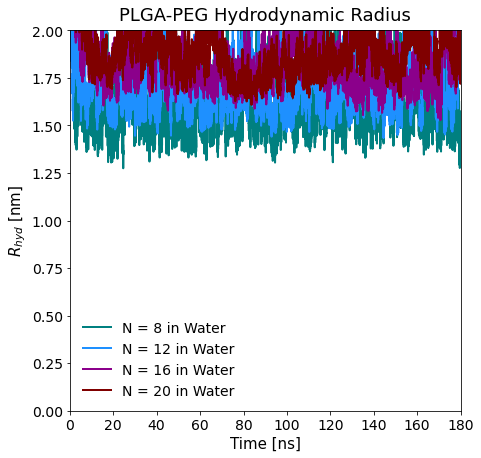

In [175]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat75LGA25EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat75LGA25EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat75LGA25EG_rh/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n20wat75LGA25EG_rh/10,linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water','N = 20 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [176]:
ACn20wat75LGA25EG_Rh, eqvarRh_n20wat75LGA25EG = obs_autocorr_RA(n20wat75LGA25EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [177]:
ACn20wat75LGA25EG_Rh

array([[ 1.00000000e+00,  8.61708288e-01,  8.37224039e-01, ...,
        -4.71443711e-01, -3.94140596e-01, -3.51941579e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [178]:
eqvarRh_n20wat75LGA25EG

3.6600652154167506

(0.0, 20.0)

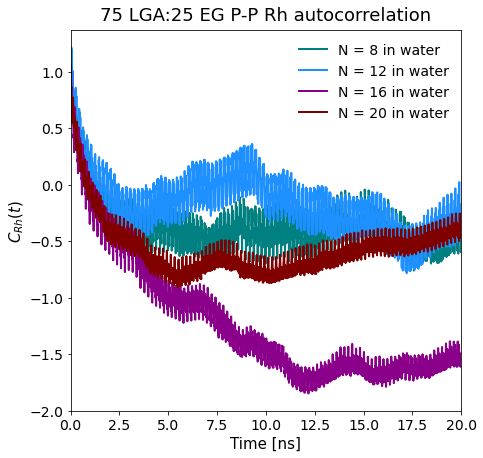

In [179]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rh[1]/100, ACn8wat75LGA25EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rh[1]/100, ACn12wat75LGA25EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rh[1]/100, ACn16wat75LGA25EG_Rh[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Rh[1]/100, ACn20wat75LGA25EG_Rh[0],linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water','N = 20 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 20 75LGA:25EG in water

In [180]:
n2075LGA25EG_rgens_wat, cor_n2075LGA25EG_wat, n2075LGA25EG_cos_wat, rgwat_n2075LGA25EG = get_rg_pers_poly(n20wat_75LGA25EG, n20_75LGA_25EG_wat,
                                                                                                  start,end)

In [181]:
n2075LGA25EG_rgens_wat[0].shape

(18001,)

In [182]:
cor_n2075LGA25EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])

In [183]:
n2075LGA25EG_cos_wat

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99102659, 0.98011137, 0.96760435, ..., 0.80962369, 0.7993174 ,
        0.81932707],
       [0.98633825, 0.97462131, 0.9361474 , ..., 0.5818456 , 0.55682691,
        0.58899055],
       ...,
       [0.99302304, 0.98513359, 0.94832044, ..., 0.41872082, 0.48206782,
        0.38210413],
       [0.99121021, 0.99308777, 0.94030713, ..., 0.23010664, 0.3285468 ,
        0.30225801],
       [0.98422035, 0.99106912, 0.91253316, ..., 0.77318738, 0.75218524,
        0.54548977]])

In [184]:
rgwat_n2075LGA25EG

8.483470303108588

In [185]:
n2075LGA25EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

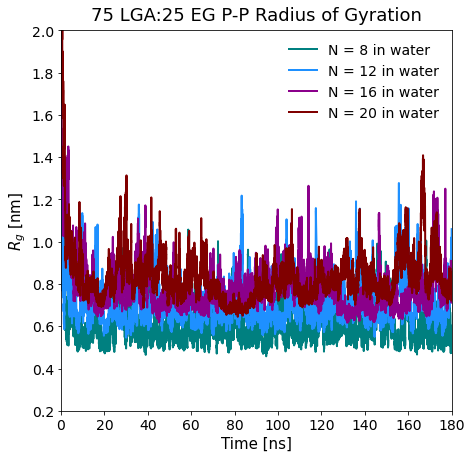

In [186]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n875LGA25EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1275LGA25EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1675LGA25EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n2075LGA25EG_rgens_wat[0]/10,linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water','N = 20 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [187]:
ACn20wat75LGA25EG_Rg, eqvarRg_n20wat75LGA25EG = obs_autocorr_RA(n2075LGA25EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [188]:
ACn20wat75LGA25EG_Rg

array([[ 1.00000000e+00,  8.91342852e-01,  8.59132633e-01, ...,
        -2.85761143e-01, -2.82001232e-01, -2.39150388e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [189]:
eqvarRg_n20wat75LGA25EG

2.8947248419584497

(-1.0, 1.0)

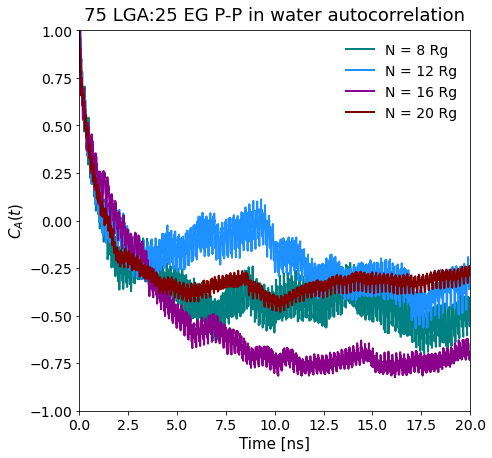

In [190]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rg[1]/100, ACn8wat75LGA25EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rg[1]/100, ACn12wat75LGA25EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rg[1]/100, ACn16wat75LGA25EG_Rg[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Rg[1]/100, ACn20wat75LGA25EG_Rg[0],linewidth=2, color='maroon')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg','N = 20 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [191]:
cb_n20plga = np.zeros(shape=(18001))
cb_n20pplinker = np.zeros(shape=(18001))
cb_n20peg = np.zeros(shape=(18001))
count = 0
for ts in n20_75LGA_25EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n20m1_plga = n20_75LGA_25EG_wat.select_atoms("resid 1")
    n20m2_plga = n20_75LGA_25EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n20pl_link = n20_75LGA_25EG_wat.select_atoms("resid 15")
    n20peg_link = n20_75LGA_25EG_wat.select_atoms("resid 16")
    # last two PEG residues 
    n20l1_peg = n20_75LGA_25EG_wat.select_atoms("resid 19")
    n20l2_peg = n20_75LGA_25EG_wat.select_atoms("resid 20")
    
    cb_n20plga[count] = mda.analysis.distances.distance_array(n20m1_plga.center_of_mass(), n20m2_plga.center_of_mass(), 
                                                   box=n20_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n20pplinker[count] = mda.analysis.distances.distance_array(n20pl_link.center_of_mass(), n20peg_link.center_of_mass(), 
                                                   box=n20_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n20peg[count] = mda.analysis.distances.distance_array(n20l1_peg.center_of_mass(), n20l2_peg.center_of_mass(), 
                                                   box=n20_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [192]:
COM_n20pp = np.zeros(shape=(3,2))
COM_n20pp[0,0] = np.mean(cb_n20plga)
COM_n20pp[1,0] = np.mean(cb_n20pplinker)
COM_n20pp[2,0] = np.mean(cb_n20peg)
COM_n20pp[0,1] = np.std(cb_n20plga)
COM_n20pp[1,1] = np.std(cb_n20pplinker)
COM_n20pp[2,1] = np.std(cb_n20peg)
COM_n20pp

array([[5.3823684 , 0.71988265],
       [4.23578265, 0.33696957],
       [3.24285586, 0.1558073 ]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 20 75LGA:25EG/water

In [193]:
# x values
blen_n20pp = np.zeros(shape=n20_mon-1)
for i in range(n20_mon-1):
    if i < int(n20_mon-5):
        # PLGA contour length values
        if i == 0:
            blen_n20pp[i] = 0
        elif i != 0:
            blen_n20pp[i] = np.sum(blen_n20pp[i-1])+ COM_n20pp[0,0]    
    elif i == int(n20_mon-5):
        #PLGA-PEG linker length
        blen_n20pp[i] = np.sum(blen_n20pp[i-1]) + COM_n20pp[1,0]
    elif i > int(n20_mon-5):
    #    # PEG contour length values
        blen_n20pp[i] = np.sum(blen_n20pp[i-1]) + COM_n20pp[2,0]
        
blen_n20pp

array([ 0.        ,  5.3823684 , 10.7647368 , 16.1471052 , 21.5294736 ,
       26.911842  , 32.2942104 , 37.67657879, 43.05894719, 48.44131559,
       53.82368399, 59.20605239, 64.58842079, 69.97078919, 75.35315759,
       79.58894024, 82.8317961 , 86.07465197, 89.31750783])

In [194]:
# Error prop. into natural log std deviation
mk_n20ppwat = cor_n2075LGA25EG_wat[1]/cor_n2075LGA25EG_wat[0]
mk_n20ppwat

array([0.        , 0.00587361, 0.0175077 , 0.03112452, 0.05004594,
       0.07021018, 0.08350782, 0.08717497, 0.10935691, 0.1294976 ,
       0.13387102, 0.14549986, 0.1678734 , 0.20001174, 0.23736093,
       0.31755488, 0.31354383, 0.34443715, 0.70166113])

<ErrorbarContainer object of 3 artists>

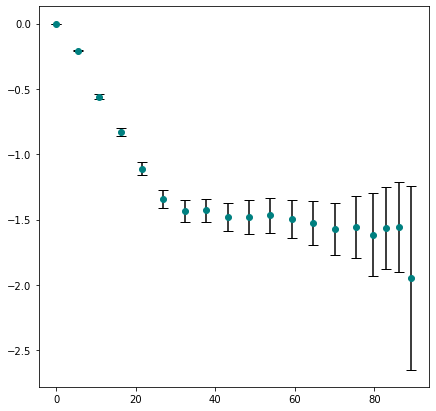

In [195]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n20pp, np.log(cor_n2075LGA25EG_wat[0]), yerr=mk_n20ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [197]:
# All the points give the best fits for N = 6 peg in water
n20_blks75LGA25EG_wat , n2075LGA25EG_lpwat = bavg_pers_cnt(5, n20wat_75LGA25EG, n20_75LGA_25EG_wat, blen_n20pp, 5, start, end)

0
3600
[1.         0.82572977 0.58332003 0.43547199 0.32114893 0.26213587
 0.22791224 0.24823267 0.24681899 0.28126076 0.32034886 0.32852144
 0.29707129 0.24630213 0.16162439 0.09206509 0.12981289 0.17359816
 0.22815712]
Lp [Angstroms]: 18.486342727009166
Error in Lp from fit [Angstroms], 95% CL : 2.676431110836021
R2 score: 0.9938294894052249
3600
7200
[1.         0.80112716 0.54596277 0.40517853 0.29281026 0.22610314
 0.20928288 0.25891947 0.28612687 0.29239098 0.293168   0.27870022
 0.26868487 0.227797   0.21425384 0.20895582 0.15251773 0.14390625
 0.07734114]
Lp [Angstroms]: 17.15139045806733
Error in Lp from fit [Angstroms], 95% CL : 2.1793187375964638
R2 score: 0.9952404058451418
7200
10800
[1.         0.81343868 0.56130628 0.40540285 0.29405919 0.22421811
 0.23381179 0.25866262 0.2770135  0.25898039 0.2229062  0.16974995
 0.18130685 0.24271796 0.3238865  0.40239715 0.43932861 0.39329775
 0.25021621]
Lp [Angstroms]: 17.117653931759165
Error in Lp from fit [Angstroms], 95% CL : 2.

In [198]:
n20_blks75LGA25EG_wat

{'Avg Hydrodynamic radius': array([19.59483947267507, 18.995756135877166, 17.650085186248365,
        18.717357451273525, 19.23349219358451], dtype=object),
 'Avg Radius of gyration': array([9.39254393, 8.37675455, 7.64344767, 8.1630168 , 8.74091497]),
 'Avg Sq. radius of gyration': array([88.21988154, 70.1700168 , 58.42229228, 66.63484327, 76.40359446]),
 'Avg end to end distance': array([22.87320569, 19.4659231 , 16.3576977 , 13.47214854, 19.36729961]),
 'Avg Sq. end to end distance': array([523.18353862, 378.92216213, 267.57427391, 181.49878617,
        375.09229403]),
 'Avg persistence length': array([18.48634273, 17.15139046, 17.11765393, 22.29867496, 20.15456601])}

In [199]:
n2075LGA25EG_lpwat

array([[ 1.84863427e+01,  1.71513905e+01,  1.71176539e+01,
         2.22986750e+01,  2.01545660e+01],
       [ 2.67643111e+00,  2.17931874e+00,  2.48279542e+00,
         4.06845467e+00,  2.24347225e+00],
       [-5.40939879e-02, -5.83043108e-02, -5.84192205e-02,
        -4.48457140e-02, -4.96165484e-02],
       [ 1.75441692e-03,  1.56988862e-03,  2.05366486e-03,
         1.91499395e-03,  8.72513727e-04]])

In [200]:
n2075LGA25EG_lpwat[2]

array([-0.05409399, -0.05830431, -0.05841922, -0.04484571, -0.04961655])

In [201]:
np.mean(n2075LGA25EG_lpwat[3])

0.0016330956155653855

#### Block averaged Radius of gyration and persistence length, N = 20 75LGA:25EG/water

In [202]:
np.mean(n20_blks75LGA25EG_wat["Avg Radius of gyration"])

8.463335584000781

In [203]:
np.std(n20_blks75LGA25EG_wat["Avg Radius of gyration"])

0.5848730305159578

In [204]:
rg75LGA25EG_olig_wat[r"$R_{g}$ [Angstrom] N = 20 75LGA:25EG water"] = n20_blks75LGA25EG_wat["Avg Radius of gyration"]
rg75LGA25EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 75LGA:25EG water,$R_{g}$ [Angstrom] N = 12 75LGA:25EG water,$R_{g}$ [Angstrom] N = 16 75LGA:25EG water,$R_{g}$ [Angstrom] N = 20 75LGA:25EG water
0,6.530453,7.275377,8.742289,9.392544
1,5.968490,6.991761,7.471333,8.376755
2,6.070411,6.988424,7.999952,7.643448
3,6.143032,7.222598,7.635412,8.163017
4,6.097685,7.344096,7.716382,8.740915


In [205]:
pers_75LGA25EG_wat[r"$L_{p}$ [Angstrom] N = 20 75LGA:25EG water"] = n20_blks75LGA25EG_wat["Avg persistence length"]
pers_75LGA25EG_wat

,$L_{p}$ [Angstrom] N = 8 75LGA:25EG water,$L_{p}$ [Angstrom] N = 12 75LGA:25EG water,$L_{p}$ [Angstrom] N = 16 75LGA:25EG water,$L_{p}$ [Angstrom] N = 20 75LGA:25EG water
0,17.608703,18.354992,21.856489,18.486343
1,16.586692,18.850102,17.152592,17.151390
2,16.347702,17.095107,18.132619,17.117654
3,17.914893,17.394729,18.063131,22.298675
4,16.502247,18.065975,19.948746,20.154566


### N = 28 75LGA:25EG in water

In [211]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n28_75LGA_25EG_wat = mda.Universe("n2875LGA_25EG/n28_75LGA25EG_WAT.pdb", "n2875LGA_25EG/NoWatn28_75LGA25EG.xtc")

In [212]:
n28_75LGA_25EG_wat.trajectory

<XTCReader n2875LGA_25EG/NoWatn28_75LGA25EG.xtc with 18001 frames of 367 atoms>

In [213]:
len(n28_75LGA_25EG_wat.trajectory)

18001

In [214]:
#Select the polymer heavy atoms 
n28wat_75LGA25EG = n28_75LGA_25EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [215]:
np.unique(n28wat_75LGA25EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [216]:
# Get cosine theta values at frame 0 
crv_n28wat_75LGA25EG = pers_length(n28wat_75LGA25EG,28)
crv_n28wat_75LGA25EG

array([[ 1.        ,  0.87887467,  0.8203834 ,  0.82460694,  0.80313503,
         0.76246789,  0.750239  ,  0.80699641,  0.82555228,  0.834125  ,
         0.83613044,  0.82400902,  0.81204072,  0.79386337,  0.78207478,
         0.77086946,  0.77546894,  0.76146184,  0.74682465,  0.83608038,
         0.8276842 ,  0.81164241,  0.81109191,  0.82955808,  0.82298878,
         0.90383685,  0.94222941],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        ],
       [ 0.        , 28.49308816, 34.8768082 , 34.45133866, 36.56947291,
        40.31775266, 41.38891474, 36.19649838, 34.35547621, 33.47516359,
        33.26626847, 34.51185038, 35.70420309, 37.4519

### Mean squared end to end distance 

In [217]:
n28_mon = 28
start = 0
end = 18001
trj_len = np.arange(18001)

In [218]:
eVec_n28wat75LGA25EG, e2edis_n28wat75LGA25EG = mean_sq_e2e(n28wat_75LGA25EG, n28_75LGA_25EG_wat, n28_mon, start, end)

(0.0, 5.0)

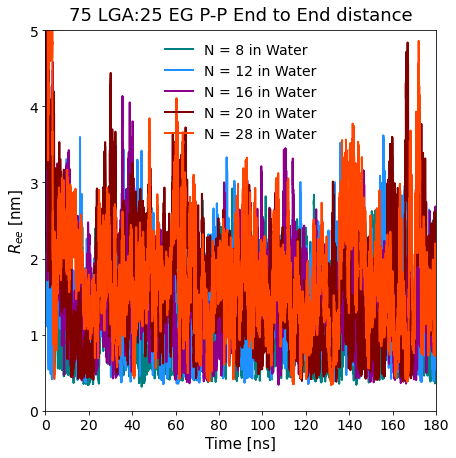

In [219]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat75LGA25EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat75LGA25EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat75LGA25EG[1]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, e2edis_n20wat75LGA25EG[1]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, e2edis_n28wat75LGA25EG[1]/10,linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,5)

#### Ree Autocorrelation function

In [220]:
e2edis_n28wat75LGA25EG[1]

array([99.30222871, 99.80857433, 95.3871459 , ..., 17.15264407,
       16.60151832, 19.50816695])

In [ ]:
t_corr = 2000
window_shift = 20

In [221]:
ACn28wat75LGA25EG_Ree, eqvar_n28wat75LGA25EG = obs_autocorr_RA(e2edis_n28wat75LGA25EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [222]:
ACn28wat75LGA25EG_Ree

array([[ 1.00000000e+00,  9.97858156e-01,  9.77394573e-01, ...,
        -4.16028296e-01, -4.19549226e-01, -4.19497464e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [223]:
eqvar_n28wat75LGA25EG

77.02027999552377

In [224]:
ACn28wat75LGA25EG_sqRee, evsqRee_n28wat75LGA25EG = obs_autocorr_RA(e2edis_n28wat75LGA25EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [225]:
np.sqrt(evsqRee_n28wat75LGA25EG)

614.9421930675267

(-1.0, 1.0)

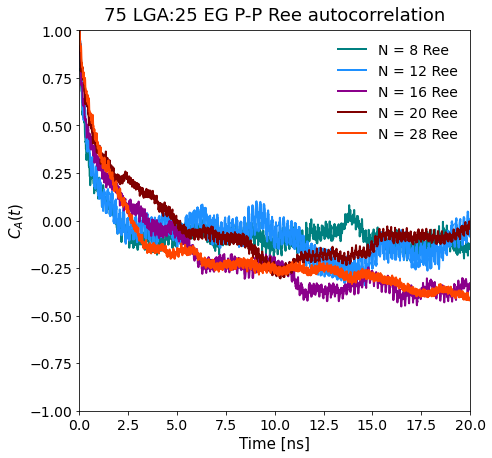

In [226]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Ree[1]/100, ACn8wat75LGA25EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Ree[1]/100, ACn12wat75LGA25EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Ree[1]/100, ACn16wat75LGA25EG_Ree[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Ree[1]/100, ACn20wat75LGA25EG_Ree[0],linewidth=2, color='maroon')
plt.plot(ACn28wat75LGA25EG_Ree[1]/100, ACn28wat75LGA25EG_Ree[0],linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree','N = 20 Ree','N = 28 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [227]:
n28wat75LGA25EG_rh = hydro_rad_poly(n28wat_75LGA25EG, n28_75LGA_25EG_wat, n28_mon, start, end)

(0.0, 2.0)

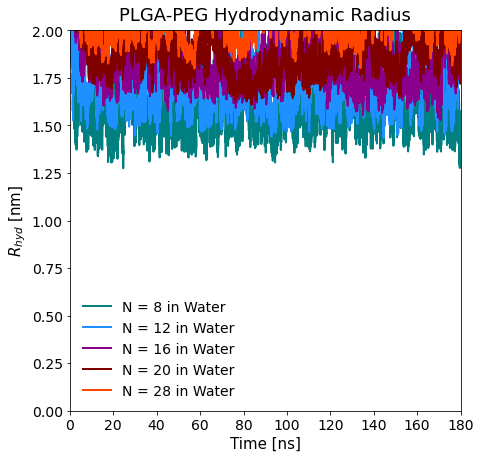

In [228]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat75LGA25EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat75LGA25EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat75LGA25EG_rh/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n20wat75LGA25EG_rh/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n28wat75LGA25EG_rh/10,linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,2)

#### Rh autocorrelation

In [229]:
ACn28wat75LGA25EG_Rh, eqvarRh_n28wat75LGA25EG = obs_autocorr_RA(n28wat75LGA25EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [230]:
ACn28wat75LGA25EG_Rh

array([[ 1.00000000e+00,  9.87553544e-01,  9.54891728e-01, ...,
        -9.06013717e-01, -8.80528628e-01, -9.12967843e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [231]:
eqvarRh_n28wat75LGA25EG

4.147871055228052

(0.0, 20.0)

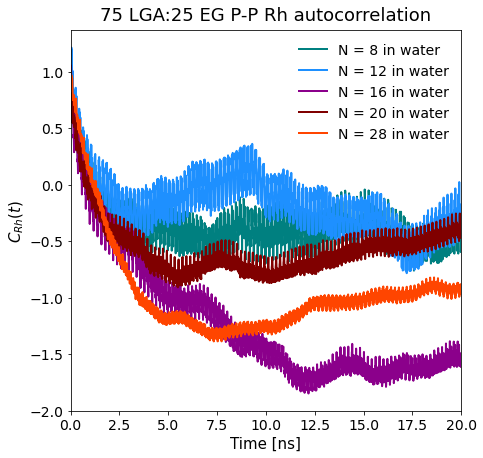

In [232]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rh[1]/100, ACn8wat75LGA25EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rh[1]/100, ACn12wat75LGA25EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rh[1]/100, ACn16wat75LGA25EG_Rh[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Rh[1]/100, ACn20wat75LGA25EG_Rh[0],linewidth=2, color='maroon')
plt.plot(ACn28wat75LGA25EG_Rh[1]/100, ACn28wat75LGA25EG_Rh[0],linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 28 75LGA:25EG in water

In [233]:
n2875LGA25EG_rgens_wat, cor_n2875LGA25EG_wat, n2875LGA25EG_cos_wat, rgwat_n2875LGA25EG = get_rg_pers_poly(n28wat_75LGA25EG, n28_75LGA_25EG_wat,
                                                                                                  start,end)

In [234]:
n2875LGA25EG_rgens_wat[0].shape

(18001,)

In [235]:
cor_n2875LGA25EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26.])

In [236]:
n2875LGA25EG_cos_wat

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.87887467,  0.89290307,  0.89492243, ...,  0.78084963,
         0.77420958,  0.78646119],
       [ 0.8203834 ,  0.84525722,  0.85131728, ...,  0.55123125,
         0.5561647 ,  0.5683601 ],
       ...,
       [ 0.82298878,  0.85114052,  0.95743517, ..., -0.12878286,
        -0.18463762, -0.10984278],
       [ 0.90383685,  0.94075238,  0.94766982, ..., -0.18547826,
        -0.1255189 , -0.1325532 ],
       [ 0.94222941,  0.9914828 ,  0.99415356, ...,  0.36268712,
         0.57181124,  0.60267321]])

In [237]:
rgwat_n2875LGA25EG

9.487117823243024

In [238]:
n2875LGA25EG_rgens_wat.shape

(2, 18001)

(0.2, 2.0)

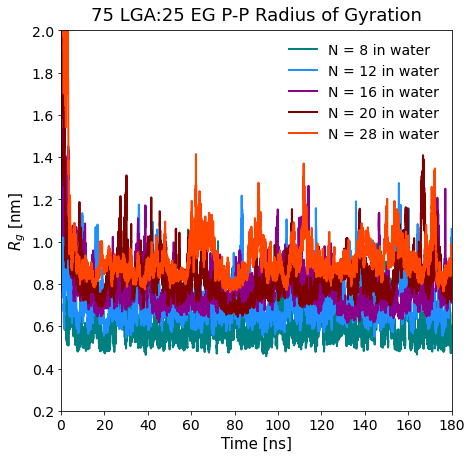

In [239]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n875LGA25EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1275LGA25EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1675LGA25EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n2075LGA25EG_rgens_wat[0]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n2875LGA25EG_rgens_wat[0]/10,linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

#### Rg Autocorrelation

In [240]:
ACn28wat75LGA25EG_Rg, eqvarRg_n28wat75LGA25EG = obs_autocorr_RA(n2875LGA25EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [241]:
ACn28wat75LGA25EG_Rg

array([[ 1.00000000e+00,  9.89876025e-01,  9.70413055e-01, ...,
        -6.02461178e-01, -5.90308777e-01, -5.84517240e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [242]:
eqvarRg_n28wat75LGA25EG

4.155347598437984

(-1.0, 1.0)

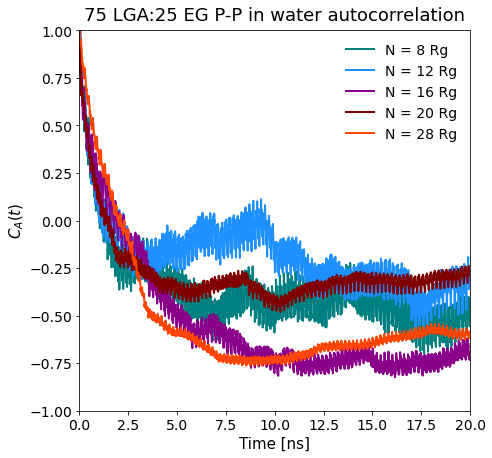

In [243]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rg[1]/100, ACn8wat75LGA25EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rg[1]/100, ACn12wat75LGA25EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rg[1]/100, ACn16wat75LGA25EG_Rg[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Rg[1]/100, ACn20wat75LGA25EG_Rg[0],linewidth=2, color='maroon')
plt.plot(ACn28wat75LGA25EG_Rg[1]/100, ACn28wat75LGA25EG_Rg[0],linewidth=2, color='orangered')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg','N = 20 Rg','N = 28 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [244]:
cb_n28plga = np.zeros(shape=(18001))
cb_n28pplinker = np.zeros(shape=(18001))
cb_n28peg = np.zeros(shape=(18001))
count = 0
for ts in n28_75LGA_25EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n28m1_plga = n28_75LGA_25EG_wat.select_atoms("resid 1")
    n28m2_plga = n28_75LGA_25EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n28pl_link = n28_75LGA_25EG_wat.select_atoms("resid 21")
    n28peg_link = n28_75LGA_25EG_wat.select_atoms("resid 22")
    # last two PEG residues 
    n28l1_peg = n28_75LGA_25EG_wat.select_atoms("resid 27")
    n28l2_peg = n28_75LGA_25EG_wat.select_atoms("resid 28")
    
    cb_n28plga[count] = mda.analysis.distances.distance_array(n28m1_plga.center_of_mass(), n28m2_plga.center_of_mass(), 
                                                   box=n28_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n28pplinker[count] = mda.analysis.distances.distance_array(n28pl_link.center_of_mass(), n28peg_link.center_of_mass(), 
                                                   box=n28_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n28peg[count] = mda.analysis.distances.distance_array(n28l1_peg.center_of_mass(), n28l2_peg.center_of_mass(), 
                                                   box=n28_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [245]:
COM_n28pp = np.zeros(shape=(3,2))
COM_n28pp[0,0] = np.mean(cb_n28plga)
COM_n28pp[1,0] = np.mean(cb_n28pplinker)
COM_n28pp[2,0] = np.mean(cb_n28peg)
COM_n28pp[0,1] = np.std(cb_n28plga)
COM_n28pp[1,1] = np.std(cb_n28pplinker)
COM_n28pp[2,1] = np.std(cb_n28peg)
COM_n28pp

array([[5.56341045, 0.80177562],
       [4.20049051, 0.38449499],
       [3.24311822, 0.14980055]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 28 75LGA:25EG/water

In [246]:
# x values
blen_n28pp = np.zeros(shape=n28_mon-1)
for i in range(n28_mon-1):
    if i < int(n28_mon-7):
        # PLGA contour length values
        if i == 0:
            blen_n28pp[i] = 0
        elif i != 0:
            blen_n28pp[i] = np.sum(blen_n28pp[i-1])+ COM_n28pp[0,0]    
    elif i == int(n28_mon-7):
        #PLGA-PEG linker length
        blen_n28pp[i] = np.sum(blen_n28pp[i-1]) + COM_n28pp[1,0]
    elif i > int(n28_mon-7):
    #    # PEG contour length values
        blen_n28pp[i] = np.sum(blen_n28pp[i-1]) + COM_n28pp[2,0]
        
blen_n28pp

array([  0.        ,   5.56341045,  11.1268209 ,  16.69023135,
        22.25364179,  27.81705224,  33.38046269,  38.94387314,
        44.50728359,  50.07069404,  55.63410449,  61.19751493,
        66.76092538,  72.32433583,  77.88774628,  83.45115673,
        89.01456718,  94.57797763, 100.14138807, 105.70479852,
       111.26820897, 115.46869948, 118.7118177 , 121.95493592,
       125.19805415, 128.44117237, 131.68429059])

In [247]:
# Error prop. into natural log std deviation
mk_n28ppwat = cor_n2875LGA25EG_wat[1]/cor_n2875LGA25EG_wat[0]
mk_n28ppwat

array([0.        , 0.00400601, 0.01152326, 0.02044923, 0.03570024,
       0.05514656, 0.07381769, 0.07565501, 0.08085811, 0.106055  ,
       0.14379638, 0.15666378, 0.13505514, 0.11628362, 0.12450466,
       0.14917916, 0.16254306, 0.20475787, 0.23924896, 0.19189493,
       0.16901205, 0.24254861, 0.42824225, 0.40843892, 0.58820409,
       0.71701686, 0.75020969])

<ErrorbarContainer object of 3 artists>

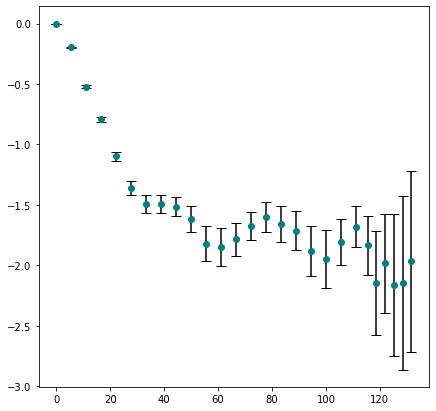

In [248]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n28pp, np.log(cor_n2875LGA25EG_wat[0]), yerr=mk_n28ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [249]:
# All the points give the best fits for N = 6 peg in water
n28_blks75LGA25EG_wat , n2875LGA25EG_lpwat = bavg_pers_cnt(5, n28wat_75LGA25EG, n28_75LGA_25EG_wat, blen_n28pp, 5, start, end)

0
3600
[1.         0.82369425 0.59984947 0.46179663 0.3270323  0.26041304
 0.2525445  0.25656522 0.22778245 0.16076326 0.09852961 0.08450301
 0.13351496 0.22333725 0.31650015 0.36754027 0.34897196 0.27670171
 0.21977946 0.21146843 0.23895774 0.20031858 0.12885406 0.1020787
 0.0188462  0.06231677 0.22688111]
Lp [Angstroms]: 19.769996839582763
Error in Lp from fit [Angstroms], 95% CL : 3.147556550078462
R2 score: 0.9925478017469456
3600
7200
[1.         0.82383433 0.59743495 0.45855588 0.33320668 0.25519812
 0.22182454 0.22693819 0.23471826 0.23466789 0.19996842 0.16810908
 0.15843604 0.14026398 0.15362827 0.14289402 0.17851431 0.18154239
 0.22775495 0.26387544 0.27130029 0.23975571 0.18222397 0.21523242
 0.14937828 0.14001944 0.35228097]
Lp [Angstroms]: 19.98443403427922
Error in Lp from fit [Angstroms], 95% CL : 2.7907249189126073
R2 score: 0.9942568779911586
7200
10800
[ 1.          0.82072714  0.58109026  0.43373064  0.33116467  0.27277558
  0.21952688  0.21311263  0.22114045  0.2007

In [250]:
n28_blks75LGA25EG_wat

{'Avg Hydrodynamic radius': array([20.771884682800746, 20.519749414513356, 20.515088255256316,
        20.5376258237176, 20.8726123818252], dtype=object),
 'Avg Radius of gyration': array([10.66820451,  9.22026975,  8.87740347,  9.26819861,  9.30016807]),
 'Avg Sq. radius of gyration': array([113.81058749,  85.01337431,  78.80829237,  85.89950555,
         86.4931261 ]),
 'Avg end to end distance': array([25.4978204 , 19.19350966, 17.32996237, 17.96092881, 18.33831747]),
 'Avg Sq. end to end distance': array([650.13884497, 368.39081298, 300.32759587, 322.59496366,
        336.29388746]),
 'Avg persistence length': array([19.76999684, 19.98443403, 19.53413067, 19.05881974, 21.28857168])}

In [251]:
n2875LGA25EG_lpwat

array([[ 1.97699968e+01,  1.99844340e+01,  1.95341307e+01,
         1.90588197e+01,  2.12885717e+01],
       [ 3.14755655e+00,  2.79072492e+00,  2.60224738e+00,
         3.73647789e+00,  2.90124270e+00],
       [-5.05816975e-02, -5.00389452e-02, -5.11924496e-02,
        -5.24691462e-02, -4.69735600e-02],
       [ 1.98189534e-03,  1.49219878e-03,  1.42128391e-03,
         3.23370842e-03,  1.25239711e-03]])

In [252]:
n2875LGA25EG_lpwat[2]

array([-0.0505817 , -0.05003895, -0.05119245, -0.05246915, -0.04697356])

In [253]:
np.mean(n2875LGA25EG_lpwat[3])

0.0018762967138049567

#### Block averaged Radius of gyration and persistence length, N = 28 75LGA:25EG/water

In [254]:
np.mean(n28_blks75LGA25EG_wat["Avg Radius of gyration"])

9.46684888321617

In [255]:
np.std(n28_blks75LGA25EG_wat["Avg Radius of gyration"])

0.6194750891601631

In [256]:
rg75LGA25EG_olig_wat[r"$R_{g}$ [Angstrom] N = 28 75LGA:25EG water"] = n28_blks75LGA25EG_wat["Avg Radius of gyration"]
rg75LGA25EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 75LGA:25EG water,$R_{g}$ [Angstrom] N = 12 75LGA:25EG water,$R_{g}$ [Angstrom] N = 16 75LGA:25EG water,$R_{g}$ [Angstrom] N = 20 75LGA:25EG water,$R_{g}$ [Angstrom] N = 28 75LGA:25EG water
0,6.530453,7.275377,8.742289,9.392544,10.668205
1,5.968490,6.991761,7.471333,8.376755,9.220270
2,6.070411,6.988424,7.999952,7.643448,8.877403
3,6.143032,7.222598,7.635412,8.163017,9.268199
4,6.097685,7.344096,7.716382,8.740915,9.300168


In [257]:
pers_75LGA25EG_wat[r"$L_{p}$ [Angstrom] N = 28 75LGA:25EG water"] = n28_blks75LGA25EG_wat["Avg persistence length"]
pers_75LGA25EG_wat

,$L_{p}$ [Angstrom] N = 8 75LGA:25EG water,$L_{p}$ [Angstrom] N = 12 75LGA:25EG water,$L_{p}$ [Angstrom] N = 16 75LGA:25EG water,$L_{p}$ [Angstrom] N = 20 75LGA:25EG water,$L_{p}$ [Angstrom] N = 28 75LGA:25EG water
0,17.608703,18.354992,21.856489,18.486343,19.769997
1,16.586692,18.850102,17.152592,17.151390,19.984434
2,16.347702,17.095107,18.132619,17.117654,19.534131
3,17.914893,17.394729,18.063131,22.298675,19.058820
4,16.502247,18.065975,19.948746,20.154566,21.288572


### N = 32 75LGA:25EG in water

In [258]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n32_75LGA_25EG_wat = mda.Universe("n3275LGA_25EG/n32_75LGA25EG_WAT.pdb", "n3275LGA_25EG/NoWatn32_75LGA25EG.xtc")

In [259]:
n32_75LGA_25EG_wat.trajectory

<XTCReader n3275LGA_25EG/NoWatn32_75LGA25EG.xtc with 18001 frames of 419 atoms>

In [260]:
len(n32_75LGA_25EG_wat.trajectory)

18001

In [261]:
#Select the polymer heavy atoms 
n32wat_75LGA25EG = n32_75LGA_25EG_wat.select_atoms("resname sPLG PLG bPLG bPEG PEG sPEG and not type H")

In [262]:
np.unique(n32wat_75LGA25EG.resids)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [263]:
# Get cosine theta values at frame 0 
crv_n32wat_75LGA25EG = pers_length(n32wat_75LGA25EG,32)
crv_n32wat_75LGA25EG

array([[ 1.        ,  0.9025763 ,  0.84694687,  0.82130058,  0.79685337,
         0.79140368,  0.77767719,  0.76654432,  0.78978218,  0.80332484,
         0.81564538,  0.81411829,  0.81426339,  0.80640953,  0.80130652,
         0.81518518,  0.80670421,  0.82994431,  0.81637822,  0.80733635,
         0.7943397 ,  0.7867884 ,  0.76548008,  0.76974447,  0.74314449,
         0.72731675,  0.74549448,  0.75247509,  0.70263265,  0.5889114 ,
         0.18266257],
       [ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        , 27.        , 28.        , 29.        ,
        30.        ],
       [ 0.        , 25.50119625, 32.11886961, 34.78480078, 37.16933677,
       

### Mean squared end to end distance 

In [264]:
n32_mon = 32
start = 0
end = 18001
trj_len = np.arange(18001)

In [265]:
eVec_n32wat75LGA25EG, e2edis_n32wat75LGA25EG = mean_sq_e2e(n32wat_75LGA25EG, n32_75LGA_25EG_wat, n32_mon, start, end)

(0.0, 12.0)

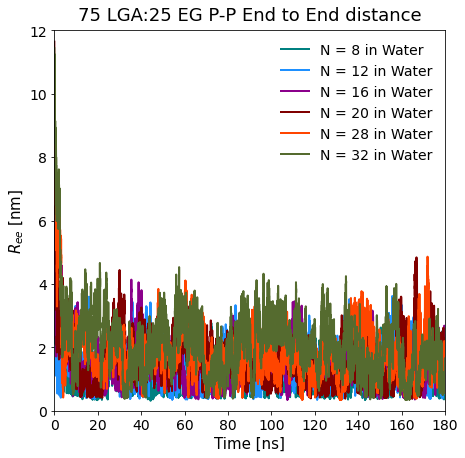

In [313]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P End to End distance', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{ee}$ [nm]', fontsize=15)
plt.plot(trj_len/100, e2edis_n8wat75LGA25EG[1]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, e2edis_n12wat75LGA25EG[1]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, e2edis_n16wat75LGA25EG[1]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, e2edis_n20wat75LGA25EG[1]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, e2edis_n28wat75LGA25EG[1]/10,linewidth=2, color='orangered')
plt.plot(trj_len/100, e2edis_n32wat75LGA25EG[1]/10,linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,12)

In [267]:
np.save('n8_75LGA25EG_ReeWAT.npy',e2edis_n8wat75LGA25EG)
np.save('n12_75LGA25EG_ReeWAT.npy',e2edis_n12wat75LGA25EG)
np.save('n16_75LGA25EG_ReeWAT.npy',e2edis_n16wat75LGA25EG)
np.save('n20_75LGA25EG_ReeWAT.npy',e2edis_n20wat75LGA25EG)
np.save('n28_75LGA25EG_ReeWAT.npy',e2edis_n28wat75LGA25EG)
np.save('n32_75LGA25EG_ReeWAT.npy',e2edis_n32wat75LGA25EG)

#### Ree Autocorrelation function

In [268]:
e2edis_n32wat75LGA25EG[1]

array([114.34279673, 111.17255818, 109.4438673 , ...,  14.28936581,
        16.12537255,  16.45883303])

In [ ]:
t_corr = 2000
window_shift = 20

In [269]:
ACn32wat75LGA25EG_Ree, eqvar_n32wat75LGA25EG = obs_autocorr_RA(e2edis_n32wat75LGA25EG[1],t_corr, window_shift,start,end)

No. of Samples: 801


In [270]:
ACn32wat75LGA25EG_Ree

array([[ 1.00000000e+00,  9.85583617e-01,  9.47286305e-01, ...,
        -4.00450183e-01, -3.84636029e-01, -3.95308732e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [271]:
eqvar_n32wat75LGA25EG

123.60158367826273

In [272]:
ACn32wat75LGA25EG_sqRee, evsqRee_n32wat75LGA25EG = obs_autocorr_RA(e2edis_n32wat75LGA25EG[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [273]:
np.sqrt(evsqRee_n32wat75LGA25EG)

884.046634566232

(-1.0, 1.0)

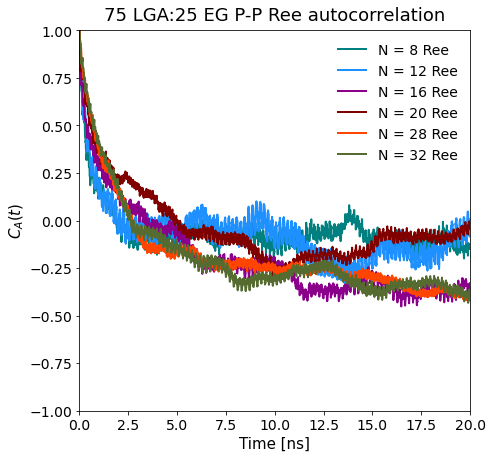

In [274]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Ree autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Ree[1]/100, ACn8wat75LGA25EG_Ree[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Ree[1]/100, ACn12wat75LGA25EG_Ree[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Ree[1]/100, ACn16wat75LGA25EG_Ree[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Ree[1]/100, ACn20wat75LGA25EG_Ree[0],linewidth=2, color='maroon')
plt.plot(ACn28wat75LGA25EG_Ree[1]/100, ACn28wat75LGA25EG_Ree[0],linewidth=2, color='orangered')
plt.plot(ACn32wat75LGA25EG_Ree[1]/100, ACn32wat75LGA25EG_Ree[0],linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Ree','N = 12 Ree','N = 16 Ree','N = 20 Ree','N = 28 Ree','N = 32 Ree'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

### Hydrodynamic Radius vs time

In [275]:
n32wat75LGA25EG_rh = hydro_rad_poly(n32wat_75LGA25EG, n32_75LGA_25EG_wat, n32_mon, start, end)

(0.0, 6.0)

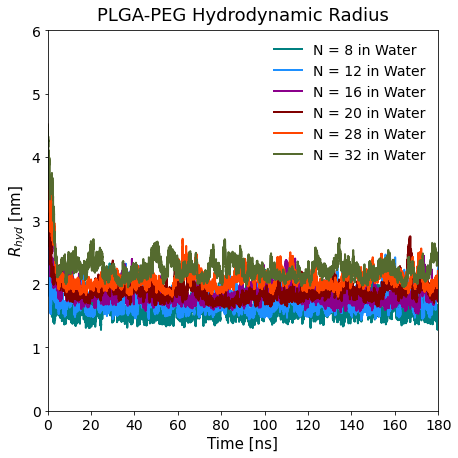

In [315]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA-PEG Hydrodynamic Radius', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{hyd}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n8wat75LGA25EG_rh/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n12wat75LGA25EG_rh/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n16wat75LGA25EG_rh/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n20wat75LGA25EG_rh/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n28wat75LGA25EG_rh/10,linewidth=2, color='orangered')
plt.plot(trj_len/100, n32wat75LGA25EG_rh/10,linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in Water','N = 12 in Water','N = 16 in Water'
            ,'N = 20 in Water','N = 28 in Water','N = 32 in Water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0,6)

In [277]:
np.save('n8_75LGA25EG_RHYDwat.npy',n8wat75LGA25EG_rh)
np.save('n12_75LGA25EG_RHYDwat.npy',n12wat75LGA25EG_rh)
np.save('n16_75LGA25EG_RHYDwat.npy',n16wat75LGA25EG_rh)
np.save('n20_75LGA25EG_RHYDwat.npy',n20wat75LGA25EG_rh)
np.save('n28_75LGA25EG_RHYDwat.npy',n28wat75LGA25EG_rh)
np.save('n32_75LGA25EG_RHYDwat.npy',n32wat75LGA25EG_rh)

#### Rh autocorrelation

In [278]:
ACn32wat75LGA25EG_Rh, eqvarRh_n32wat75LGA25EG = obs_autocorr_RA(n32wat75LGA25EG_rh,t_corr, window_shift,start,end)

No. of Samples: 801


In [279]:
ACn32wat75LGA25EG_Rh

array([[ 1.00000000e+00,  9.69556617e-01,  9.99738349e-01, ...,
        -1.44751436e+00, -1.42022190e+00, -1.40687360e+00],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [280]:
eqvarRh_n32wat75LGA25EG

5.822287127019763

(0.0, 20.0)

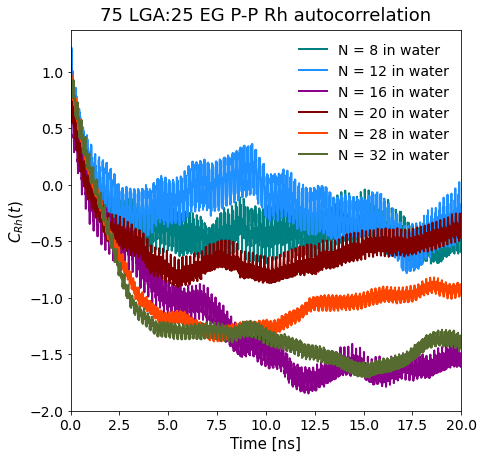

In [281]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Rh autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{Rh}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rh[1]/100, ACn8wat75LGA25EG_Rh[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rh[1]/100, ACn12wat75LGA25EG_Rh[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rh[1]/100, ACn16wat75LGA25EG_Rh[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Rh[1]/100, ACn20wat75LGA25EG_Rh[0],linewidth=2, color='maroon')
plt.plot(ACn28wat75LGA25EG_Rh[1]/100, ACn28wat75LGA25EG_Rh[0],linewidth=2, color='orangered')
plt.plot(ACn32wat75LGA25EG_Rh[1]/100, ACn32wat75LGA25EG_Rh[0],linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water', 'N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water','N = 32 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,20)
#plt.ylim(-0.2,1)

### Radius of Gyration vs. time N = 32 75LGA:25EG in water

In [282]:
n3275LGA25EG_rgens_wat, cor_n3275LGA25EG_wat, n3275LGA25EG_cos_wat, rgwat_n3275LGA25EG = get_rg_pers_poly(n32wat_75LGA25EG, n32_75LGA_25EG_wat,
                                                                                                  start,end)

In [283]:
n3275LGA25EG_rgens_wat[0].shape

(18001,)

In [284]:
cor_n3275LGA25EG_wat[3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30.])

In [285]:
n3275LGA25EG_cos_wat

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.9025763 ,  0.90778345,  0.89459898, ...,  0.82548516,
         0.82303685,  0.82923508],
       [ 0.84694687,  0.83179933,  0.80700428, ...,  0.59418609,
         0.60343168,  0.58615298],
       ...,
       [ 0.70263265,  0.52839221,  0.49359901, ..., -0.66477904,
        -0.67231509, -0.5927544 ],
       [ 0.5889114 ,  0.53307605,  0.60353733, ..., -0.4977553 ,
        -0.49445914, -0.35481796],
       [ 0.18266257,  0.15533777,  0.25279297, ..., -0.01548867,
        -0.11814009,  0.26570868]])

In [286]:
rgwat_n3275LGA25EG

10.542342427730674

In [287]:
n3275LGA25EG_rgens_wat.shape

(2, 18001)

(0.2, 4.0)

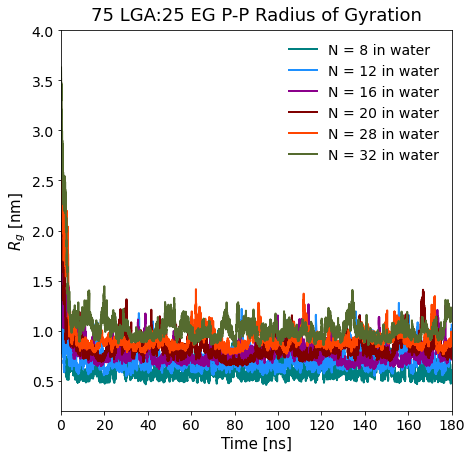

In [317]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n875LGA25EG_rgens_wat[0]/10,linewidth=2, color='teal')
plt.plot(trj_len/100, n1275LGA25EG_rgens_wat[0]/10,linewidth=2, color='dodgerblue')
plt.plot(trj_len/100, n1675LGA25EG_rgens_wat[0]/10,linewidth=2, color='darkmagenta')
plt.plot(trj_len/100, n2075LGA25EG_rgens_wat[0]/10,linewidth=2, color='maroon')
plt.plot(trj_len/100, n2875LGA25EG_rgens_wat[0]/10,linewidth=2, color='orangered')
plt.plot(trj_len/100, n3275LGA25EG_rgens_wat[0]/10,linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 in water','N = 12 in water','N = 16 in water'
            ,'N = 20 in water','N = 28 in water','N = 32 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,4)

In [289]:
np.save('n8_75LGA25EG_Rgwat.npy',n875LGA25EG_rgens_wat)
np.save('n12_75LGA25EG_Rgwat.npy',n1275LGA25EG_rgens_wat)
np.save('n16_75LGA25EG_Rgwat.npy',n1675LGA25EG_rgens_wat)
np.save('n20_75LGA25EG_Rgwat.npy',n2075LGA25EG_rgens_wat)
np.save('n28_75LGA25EG_Rgwat.npy',n2875LGA25EG_rgens_wat)
np.save('n32_75LGA25EG_Rgwat.npy',n3275LGA25EG_rgens_wat)

#### Rg Autocorrelation

In [290]:
ACn32wat75LGA25EG_Rg, eqvarRg_n32wat75LGA25EG = obs_autocorr_RA(n3275LGA25EG_rgens_wat[0],t_corr, window_shift,start,end)

No. of Samples: 801


In [291]:
ACn32wat75LGA25EG_Rg

array([[ 1.00000000e+00,  9.86386320e-01,  9.68222701e-01, ...,
        -6.86455763e-01, -6.79296525e-01, -6.79704612e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         1.99700000e+03,  1.99800000e+03,  1.99900000e+03]])

In [292]:
eqvarRg_n32wat75LGA25EG

5.31933849041792

(-1.0, 1.0)

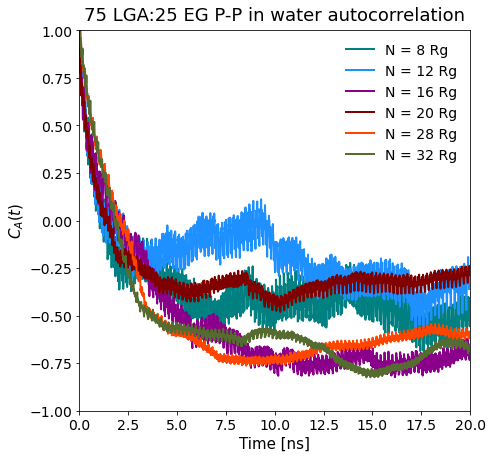

In [293]:
plt.figure(figsize=(7,7))
plt.title(r'75 LGA:25 EG P-P in water autocorrelation', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$C_{A}(t)$', fontsize=15)
plt.plot(ACn8wat75LGA25EG_Rg[1]/100, ACn8wat75LGA25EG_Rg[0],linewidth=2, color='teal')
plt.plot(ACn12wat75LGA25EG_Rg[1]/100, ACn12wat75LGA25EG_Rg[0],linewidth=2, color='dodgerblue')
plt.plot(ACn16wat75LGA25EG_Rg[1]/100, ACn16wat75LGA25EG_Rg[0],linewidth=2, color='darkmagenta')
plt.plot(ACn20wat75LGA25EG_Rg[1]/100, ACn20wat75LGA25EG_Rg[0],linewidth=2, color='maroon')
plt.plot(ACn28wat75LGA25EG_Rg[1]/100, ACn28wat75LGA25EG_Rg[0],linewidth=2, color='orangered')
plt.plot(ACn32wat75LGA25EG_Rg[1]/100, ACn32wat75LGA25EG_Rg[0],linewidth=2, color='darkolivegreen')
plt.tick_params(labelsize=14)
plt.legend(['N = 8 Rg','N = 12 Rg','N = 16 Rg','N = 20 Rg','N = 28 Rg','N = 32 Rg'], frameon=False, fontsize=14)
#plt.yscale('symlog', linthreshy=0.5)
#plt.xscale('symlog')
plt.xlim(0,20)
plt.ylim(-1,1)

#### Get average COM distance, Arc length values

In [294]:
cb_n32plga = np.zeros(shape=(18001))
cb_n32pplinker = np.zeros(shape=(18001))
cb_n32peg = np.zeros(shape=(18001))
count = 0
for ts in n32_75LGA_25EG_wat.trajectory[0:18001]:
    # 1st two PLGA residues
    n32m1_plga = n32_75LGA_25EG_wat.select_atoms("resid 1")
    n32m2_plga = n32_75LGA_25EG_wat.select_atoms("resid 2")
    # PLGA-PEG linker
    n32pl_link = n32_75LGA_25EG_wat.select_atoms("resid 23")
    n32peg_link = n32_75LGA_25EG_wat.select_atoms("resid 24")
    # last two PEG residues 
    n32l1_peg = n32_75LGA_25EG_wat.select_atoms("resid 31")
    n32l2_peg = n32_75LGA_25EG_wat.select_atoms("resid 32")
    
    cb_n32plga[count] = mda.analysis.distances.distance_array(n32m1_plga.center_of_mass(), n32m2_plga.center_of_mass(), 
                                                   box=n32_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n32pplinker[count] = mda.analysis.distances.distance_array(n32pl_link.center_of_mass(), n32peg_link.center_of_mass(), 
                                                   box=n32_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    cb_n32peg[count] = mda.analysis.distances.distance_array(n32l1_peg.center_of_mass(), n32l2_peg.center_of_mass(), 
                                                   box=n32_75LGA_25EG_wat.trajectory.ts.dimensions)
    
    count += 1
    

    

In [295]:
COM_n32pp = np.zeros(shape=(3,2))
COM_n32pp[0,0] = np.mean(cb_n32plga)
COM_n32pp[1,0] = np.mean(cb_n32pplinker)
COM_n32pp[2,0] = np.mean(cb_n32peg)
COM_n32pp[0,1] = np.std(cb_n32plga)
COM_n32pp[1,1] = np.std(cb_n32pplinker)
COM_n32pp[2,1] = np.std(cb_n32peg)
COM_n32pp

array([[5.67375795, 0.71709908],
       [5.25319632, 0.62258498],
       [3.23666065, 0.1551836 ]])

#### Correlation values at each arc length from the whole 360 ns trajectory, N = 32 75LGA:25EG/water

In [296]:
# x values
blen_n32pp = np.zeros(shape=n32_mon-1)
for i in range(n32_mon-1):
    if i < int(n32_mon-8):
        # PLGA contour length values
        if i == 0:
            blen_n32pp[i] = 0
        elif i != 0:
            blen_n32pp[i] = np.sum(blen_n32pp[i-1])+ COM_n32pp[0,0]    
    elif i == int(n32_mon-8):
        #PLGA-PEG linker length
        blen_n32pp[i] = np.sum(blen_n32pp[i-1]) + COM_n32pp[1,0]
    elif i > int(n32_mon-8):
    #    # PEG contour length values
        blen_n32pp[i] = np.sum(blen_n32pp[i-1]) + COM_n32pp[2,0]
        
blen_n32pp

array([  0.        ,   5.67375795,  11.3475159 ,  17.02127384,
        22.69503179,  28.36878974,  34.04254769,  39.71630563,
        45.39006358,  51.06382153,  56.73757948,  62.41133743,
        68.08509537,  73.75885332,  79.43261127,  85.10636922,
        90.78012717,  96.45388511, 102.12764306, 107.80140101,
       113.47515896, 119.1489169 , 124.82267485, 130.4964328 ,
       135.74962912, 138.98628977, 142.22295042, 145.45961107,
       148.69627173, 151.93293238, 155.16959303])

In [297]:
# Error prop. into natural log std deviation
mk_n32ppwat = cor_n3275LGA25EG_wat[1]/cor_n3275LGA25EG_wat[0]
mk_n32ppwat

array([0.00000000e+00, 3.68685126e-03, 1.15927391e-02, 2.22048606e-02,
       3.70404694e-02, 5.20065182e-02, 5.74069427e-02, 5.78147516e-02,
       5.66401122e-02, 6.59382118e-02, 7.67259687e-02, 8.57608784e-02,
       9.44874221e-02, 9.62378569e-02, 9.78741507e-02, 9.89776646e-02,
       1.19532764e-01, 1.39537570e-01, 1.60724365e-01, 1.77235572e-01,
       2.07072656e-01, 2.34519292e-01, 2.53085587e-01, 2.72761720e-01,
       2.74161242e-01, 3.05095734e-01, 4.34493512e-01, 8.95384439e-01,
       1.34422040e+00, 1.49855107e+00, 4.60327628e+00])

<ErrorbarContainer object of 3 artists>

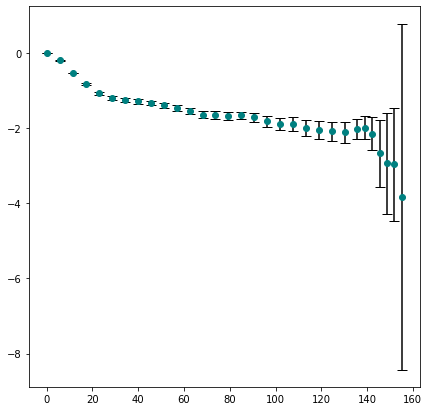

In [298]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_n32pp, np.log(cor_n3275LGA25EG_wat[0]), yerr=mk_n32ppwat, color='teal', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [299]:
# All the points give the best fits for N = 6 peg in water
n32_blks75LGA25EG_wat , n3275LGA25EG_lpwat = bavg_pers_cnt(5, n32wat_75LGA25EG, n32_75LGA_25EG_wat, blen_n32pp, 5, start, end)

0
3600
[ 1.          0.81582277  0.57372458  0.42631197  0.3652416   0.34398311
  0.32903524  0.29938578  0.25525624  0.22773249  0.22584033  0.25064869
  0.25977573  0.24667544  0.22695085  0.24521024  0.27741788  0.27936571
  0.28836049  0.2904654   0.27117844  0.26012247  0.25492241  0.2288141
  0.20946425  0.21216398  0.23038316  0.19868807  0.19837815  0.08900057
 -0.01611626]
Negative cosine theta values present, still doing linear fit...
Lp [Angstroms]: 21.30254273773778
Error in Lp from fit [Angstroms], 95% CL : 4.721898192076282
R2 score: 0.9856552015470897
3600
7200
[ 1.          0.82233272  0.57835341  0.41473786  0.32003855  0.29639298
  0.28238099  0.263136    0.2286512   0.18878424  0.16320288  0.16931356
  0.17425668  0.17367885  0.17242804  0.1395785   0.11235576  0.13329408
  0.15816244  0.20147768  0.20969646  0.20187306  0.14714563  0.11050903
  0.13490211  0.16515733  0.11323958 -0.01884693 -0.13084483 -0.09625942
 -0.083518  ]
Negative cosine theta values present, 

In [300]:
n32_blks75LGA25EG_wat

{'Avg Hydrodynamic radius': array([23.189810774263513, 22.312754272921598, 22.25183520653754,
        22.010516845836094, 21.926201414799802], dtype=object),
 'Avg Radius of gyration': array([12.44444962,  9.96682594, 10.0598998 , 10.03632875,  9.97838804]),
 'Avg Sq. radius of gyration': array([154.86432635,  99.33761928, 101.2015839 , 100.72789472,
         99.56822785]),
 'Avg end to end distance': array([31.86637675, 22.48689327, 23.01138898, 21.37928276, 17.67274   ]),
 'Avg Sq. end to end distance': array([1015.46596696,  505.66036904,  529.52402272,  457.07373148,
         312.32573916]),
 'Avg persistence length': array([21.30254274, 19.14787887, 19.82305022, 19.8848525 , 21.6344983 ])}

In [301]:
n3275LGA25EG_lpwat

array([[ 2.13025427e+01,  1.91478789e+01,  1.98230502e+01,
         1.98848525e+01,  2.16344983e+01],
       [ 4.72189819e+00,  2.98422373e+00,  2.54699491e+00,
         2.42918312e+00,  2.72851559e+00],
       [-4.69427529e-02, -5.22251058e-02, -5.04463233e-02,
        -5.02895357e-02, -4.62224724e-02],
       [ 3.44133456e-03,  2.10571462e-03,  1.33534556e-03,
         1.19963866e-03,  1.08015232e-03]])

In [302]:
n3275LGA25EG_lpwat[2]

array([-0.04694275, -0.05222511, -0.05044632, -0.05028954, -0.04622247])

In [303]:
np.mean(n3275LGA25EG_lpwat[3])

0.0018324371442369138

#### Block averaged Radius of gyration and persistence length, N = 32 75LGA:25EG/water

In [304]:
np.mean(n32_blks75LGA25EG_wat["Avg Radius of gyration"])

10.497178427989141

In [305]:
np.std(n32_blks75LGA25EG_wat["Avg Radius of gyration"])

0.9742563684834658

In [306]:
rg75LGA25EG_olig_wat[r"$R_{g}$ [Angstrom] N = 32 75LGA:25EG water"] = n32_blks75LGA25EG_wat["Avg Radius of gyration"]
rg75LGA25EG_olig_wat

,$R_{g}$ [Angstrom] N = 8 75LGA:25EG water,$R_{g}$ [Angstrom] N = 12 75LGA:25EG water,$R_{g}$ [Angstrom] N = 16 75LGA:25EG water,$R_{g}$ [Angstrom] N = 20 75LGA:25EG water,$R_{g}$ [Angstrom] N = 28 75LGA:25EG water,$R_{g}$ [Angstrom] N = 32 75LGA:25EG water
0,6.530453,7.275377,8.742289,9.392544,10.668205,12.444450
1,5.968490,6.991761,7.471333,8.376755,9.220270,9.966826
2,6.070411,6.988424,7.999952,7.643448,8.877403,10.059900
3,6.143032,7.222598,7.635412,8.163017,9.268199,10.036329
4,6.097685,7.344096,7.716382,8.740915,9.300168,9.978388


In [307]:
pers_75LGA25EG_wat[r"$L_{p}$ [Angstrom] N = 32 75LGA:25EG water"] = n32_blks75LGA25EG_wat["Avg persistence length"]
pers_75LGA25EG_wat

,$L_{p}$ [Angstrom] N = 8 75LGA:25EG water,$L_{p}$ [Angstrom] N = 12 75LGA:25EG water,$L_{p}$ [Angstrom] N = 16 75LGA:25EG water,$L_{p}$ [Angstrom] N = 20 75LGA:25EG water,$L_{p}$ [Angstrom] N = 28 75LGA:25EG water,$L_{p}$ [Angstrom] N = 32 75LGA:25EG water
0,17.608703,18.354992,21.856489,18.486343,19.769997,21.302543
1,16.586692,18.850102,17.152592,17.151390,19.984434,19.147879
2,16.347702,17.095107,18.132619,17.117654,19.534131,19.823050
3,17.914893,17.394729,18.063131,22.298675,19.058820,19.884853
4,16.502247,18.065975,19.948746,20.154566,21.288572,21.634498


In [309]:
rg75LGA25EG_olig_wat.to_pickle("75LGA25EG_wat_Rg.pkl")